
### Jupyter Notebook
##  **Learning to climb: a Trajectory Prediction model for Climb prediction**

<br>
<br>
by
<b>Gabriel Mesquida Masana</b><br>
<br>

## Packages required

In [1]:
%conda install pandas numpy matplotlib seaborn jsonpath-ng cartopy geopandas pymap3d svgpathtools svgpath2mpl

Retrieving notices: done
Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /opt/homebrew/Caskroom/miniconda/base/envs/cs230

  added / updated specs:
    - cartopy
    - geopandas
    - jsonpath-ng
    - matplotlib
    - numpy
    - pandas
    - pymap3d
    - seaborn
    - svgpath2mpl
    - svgpathtools


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    matplotlib-3.9.2           |  py310hca03da5_1           8 KB
    ------------------------------------------------------------
                                           Total:           8 KB

The following packages will be UPDATED:

  matplotlib                          3.9.2-py310hca03da5_0 --> 3.9.2-py310hca03da5_1 



                                                                                
Preparing transaction: done
Verifying transaction: done
Executi

## MLOps-specific code

In [2]:
# Set local to true if you're running it out of MLOps

LOCAL = True

In [3]:
if not LOCAL:
    
    %conda install minio mlflow boto3

    import ssl; ssl._create_default_https_context = ssl._create_stdlib_context
    

In [ ]:
if not LOCAL:
    from minio import Minio
    import pickle
    import os

    minio_client = Minio(
        os.environ["MINIO_ENDPOINT"],
        access_key=os.environ["MINIO_ACCESS_KEY"],
        secret_key=os.environ["MINIO_SECRET_KEY"],
        secure=True,
    )


def get_minio_file(bucket, object_in, file_out):

    response = minio_client.get_object(
        bucket_name=bucket,
        object_name=object_in,
    )
    with open(file_out, "wb") as file:
        file.write(response.data)

    response.close()
    response.release_conn()

    # finally:
    #     response.close()
    #     response.release_conn()

    # data=pickle.loads(obj.data)
    # with open(file_out, 'wb') as file:
    #   file.write(data)
    # pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
if not LOCAL:
    MINIO_BUCKET_NAME = "demo-bucket"
    
    !mkdir -p data
    get_minio_file(MINIO_BUCKET_NAME, "gabriel/24-05_full.pkl", "data/24-05_full.pkl")

    !mkdir -p fir
    get_minio_file(MINIO_BUCKET_NAME, "gabriel/SG_FIR.geojson", "fir/SG_FIR.geojson")


## ML imports and settings

In [ ]:
from scene import Scene
from flight import Flight as Fl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import datetime

In [1]:
# More output formatting
matplotlib.style.use("seaborn-v0_8-pastel")
pd.options.display.float_format = "{:,.2f}".format
sns.set_style("whitegrid")

# Note this configuration for retina screens only
%config InlineBackend.figure_format = 'retina'

# Only if you're editing the extensions
%load_ext autoreload
%autoreload 2

## Data from May 24

In [3]:
# Full data May 24
file_name = "24-05_full_exp.pkl"

In [4]:
scene1 = Scene(from_file=file_name)
scene1

Loaded 49884 flights


Scene with 49884 flights, loaded from 24-05_full_exp.pkl.

In [5]:
# Removing some rogue flights that seem to shoot to the moon

scene1.remove(
    [
        "13/05/2024-19:40 AWQ261 WSSS WIII A320",
        "30/05/2024-11:35 AXM140 WMKK ZGOW A320",
        "11/05/2024-10:51 VOZ9943 YPPH WSSL B738",
        "30/05/2024-20:02 SIA297 WSSS NZCH A359",
        "31/05/2024-07:09 SIA934 WSSS WADD B78X",
        "31/05/2024-13:43 AXM278 WMKK WBSB A320",
    ]
)

Removed 11/05/2024-10:51 VOZ9943 YPPH WSSL B738
Removed 13/05/2024-19:40 AWQ261 WSSS WIII A320
Removed 30/05/2024-11:35 AXM140 WMKK ZGOW A320
Removed 30/05/2024-20:02 SIA297 WSSS NZCH A359
Removed 31/05/2024-07:09 SIA934 WSSS WADD B78X
Removed 31/05/2024-13:43 AXM278 WMKK WBSB A320


## Generating departures and cleaning them up

In [6]:
scene2 = (
    Scene(from_scene=scene1)
    .departures(clean_altitudes=True)
    .aircraft(aircraft="A320")
)
scene2

Removed 761 flights


Scene with 2415 flights, copy of object (loaded from 24-05_full_exp.pkl, removed ['13/05/2024-19:40 AWQ261 WSSS WIII A320', '30/05/2024-11:35 AXM140 WMKK ZGOW A320', '11/05/2024-10:51 VOZ9943 YPPH WSSL B738', '30/05/2024-20:02 SIA297 WSSS NZCH A359', '31/05/2024-07:09 SIA934 WSSS WADD B78X', '31/05/2024-13:43 AXM278 WMKK WBSB A320'], removed ['13/05/2024-19:40 AWQ261 WSSS WIII A320', '30/05/2024-11:35 AXM140 WMKK ZGOW A320', '11/05/2024-10:51 VOZ9943 YPPH WSSL B738', '30/05/2024-20:02 SIA297 WSSS NZCH A359', '31/05/2024-07:09 SIA934 WSSS WADD B78X', '31/05/2024-13:43 AXM278 WMKK WBSB A320'], removed ['13/05/2024-19:40 AWQ261 WSSS WIII A320', '30/05/2024-11:35 AXM140 WMKK ZGOW A320', '11/05/2024-10:51 VOZ9943 YPPH WSSL B738', '30/05/2024-20:02 SIA297 WSSS NZCH A359', '31/05/2024-07:09 SIA934 WSSS WADD B78X', '31/05/2024-13:43 AXM278 WMKK WBSB A320'], removed ['13/05/2024-19:40 AWQ261 WSSS WIII A320', '30/05/2024-11:35 AXM140 WMKK ZGOW A320', '11/05/2024-10:51 VOZ9943 YPPH WSSL B738', '3

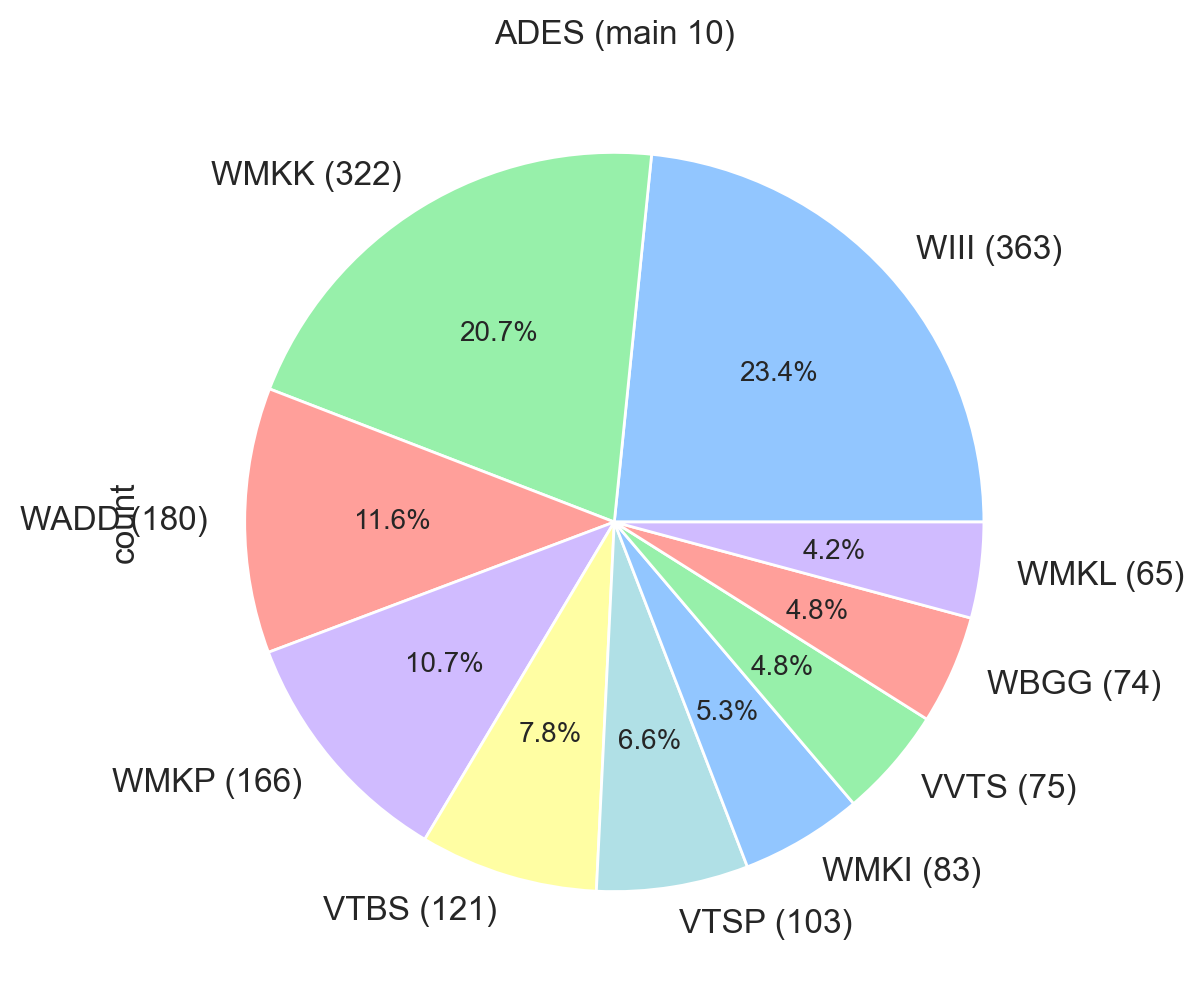

In [7]:
scene2.query_attribute(attribute="ADES", pie=True)

## Make sure FPL and Tracks are consistent

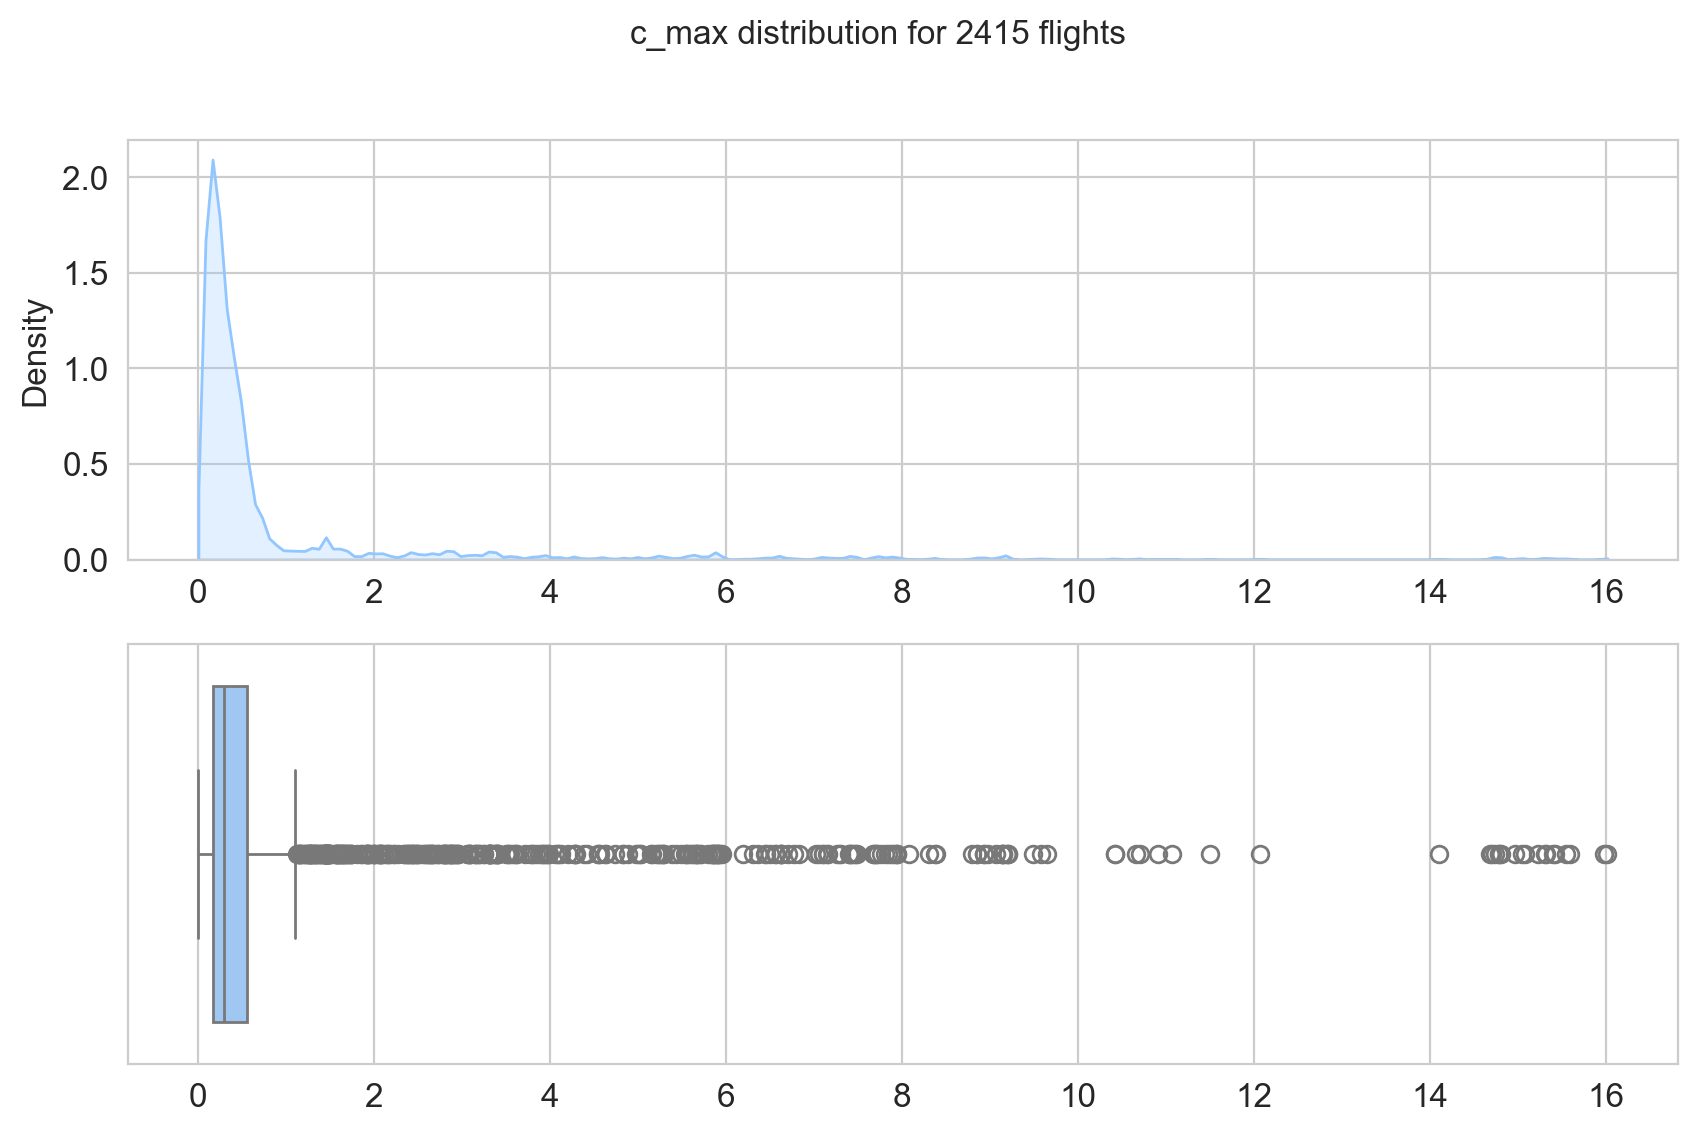

In [8]:
scene2.plot_c()

In [9]:
scene3, _ = scene2.split_c(c_threshold=1)
scene3

Scene with 2017 flights, copy of object (loaded from 24-05_full_exp.pkl, removed ['13/05/2024-19:40 AWQ261 WSSS WIII A320', '30/05/2024-11:35 AXM140 WMKK ZGOW A320', '11/05/2024-10:51 VOZ9943 YPPH WSSL B738', '30/05/2024-20:02 SIA297 WSSS NZCH A359', '31/05/2024-07:09 SIA934 WSSS WADD B78X', '31/05/2024-13:43 AXM278 WMKK WBSB A320'], removed ['13/05/2024-19:40 AWQ261 WSSS WIII A320', '30/05/2024-11:35 AXM140 WMKK ZGOW A320', '11/05/2024-10:51 VOZ9943 YPPH WSSL B738', '30/05/2024-20:02 SIA297 WSSS NZCH A359', '31/05/2024-07:09 SIA934 WSSS WADD B78X', '31/05/2024-13:43 AXM278 WMKK WBSB A320'], removed ['13/05/2024-19:40 AWQ261 WSSS WIII A320', '30/05/2024-11:35 AXM140 WMKK ZGOW A320', '11/05/2024-10:51 VOZ9943 YPPH WSSL B738', '30/05/2024-20:02 SIA297 WSSS NZCH A359', '31/05/2024-07:09 SIA934 WSSS WADD B78X', '31/05/2024-13:43 AXM278 WMKK WBSB A320'], removed ['13/05/2024-19:40 AWQ261 WSSS WIII A320', '30/05/2024-11:35 AXM140 WMKK ZGOW A320', '11/05/2024-10:51 VOZ9943 YPPH WSSL B738', '3

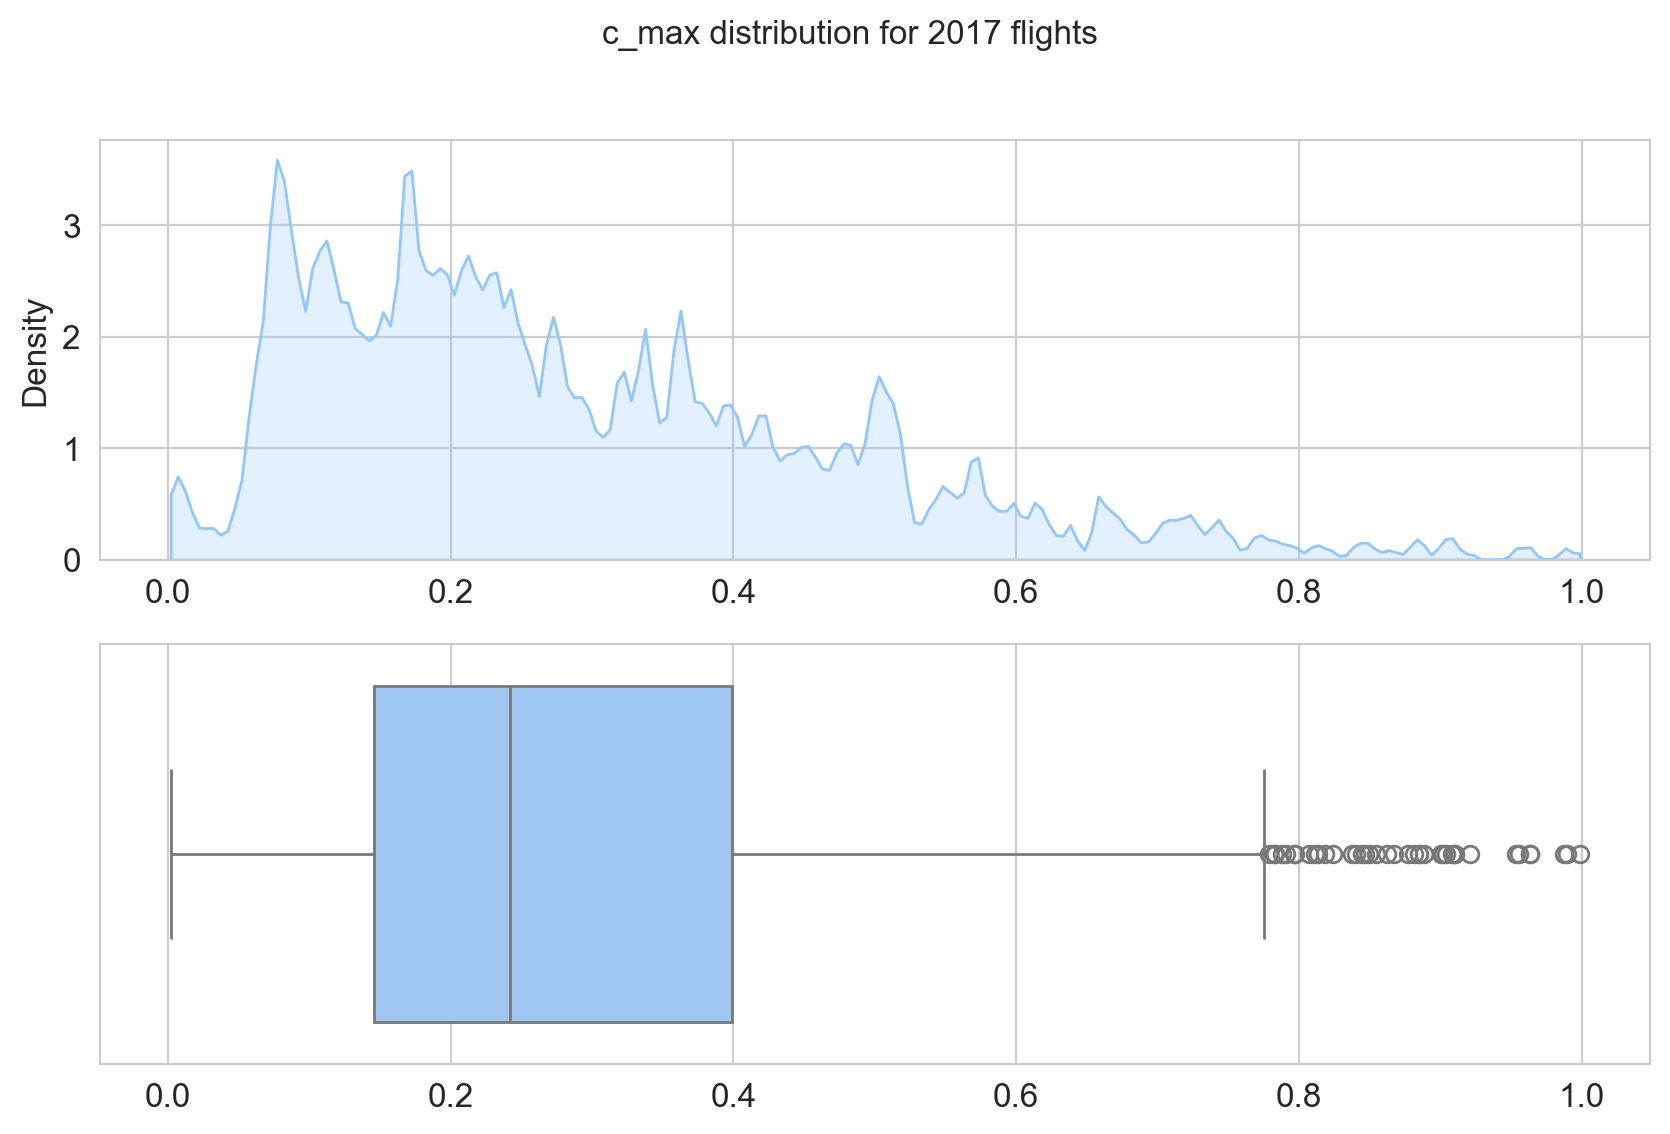

In [10]:
scene3.plot_c()

## Only the climb part

In [11]:
scene4 = Scene(from_scene=scene3).climb()
scene4

Scene with 2017 flights, copy of object (copy of object (loaded from 24-05_full_exp.pkl, removed ['13/05/2024-19:40 AWQ261 WSSS WIII A320', '30/05/2024-11:35 AXM140 WMKK ZGOW A320', '11/05/2024-10:51 VOZ9943 YPPH WSSL B738', '30/05/2024-20:02 SIA297 WSSS NZCH A359', '31/05/2024-07:09 SIA934 WSSS WADD B78X', '31/05/2024-13:43 AXM278 WMKK WBSB A320'], removed ['13/05/2024-19:40 AWQ261 WSSS WIII A320', '30/05/2024-11:35 AXM140 WMKK ZGOW A320', '11/05/2024-10:51 VOZ9943 YPPH WSSL B738', '30/05/2024-20:02 SIA297 WSSS NZCH A359', '31/05/2024-07:09 SIA934 WSSS WADD B78X', '31/05/2024-13:43 AXM278 WMKK WBSB A320'], removed ['13/05/2024-19:40 AWQ261 WSSS WIII A320', '30/05/2024-11:35 AXM140 WMKK ZGOW A320', '11/05/2024-10:51 VOZ9943 YPPH WSSL B738', '30/05/2024-20:02 SIA297 WSSS NZCH A359', '31/05/2024-07:09 SIA934 WSSS WADD B78X', '31/05/2024-13:43 AXM278 WMKK WBSB A320'], removed ['13/05/2024-19:40 AWQ261 WSSS WIII A320', '30/05/2024-11:35 AXM140 WMKK ZGOW A320', '11/05/2024-10:51 VOZ9943 YPP

### Every 8 seconds

In [12]:
scene5 = Scene(from_scene=scene4).longer(tracks=75).thin_tracks(factor=2)
scene5

Scene with 1326 flights, copy of object (copy of object (copy of object (loaded from 24-05_full_exp.pkl, removed ['13/05/2024-19:40 AWQ261 WSSS WIII A320', '30/05/2024-11:35 AXM140 WMKK ZGOW A320', '11/05/2024-10:51 VOZ9943 YPPH WSSL B738', '30/05/2024-20:02 SIA297 WSSS NZCH A359', '31/05/2024-07:09 SIA934 WSSS WADD B78X', '31/05/2024-13:43 AXM278 WMKK WBSB A320'], removed ['13/05/2024-19:40 AWQ261 WSSS WIII A320', '30/05/2024-11:35 AXM140 WMKK ZGOW A320', '11/05/2024-10:51 VOZ9943 YPPH WSSL B738', '30/05/2024-20:02 SIA297 WSSS NZCH A359', '31/05/2024-07:09 SIA934 WSSS WADD B78X', '31/05/2024-13:43 AXM278 WMKK WBSB A320'], removed ['13/05/2024-19:40 AWQ261 WSSS WIII A320', '30/05/2024-11:35 AXM140 WMKK ZGOW A320', '11/05/2024-10:51 VOZ9943 YPPH WSSL B738', '30/05/2024-20:02 SIA297 WSSS NZCH A359', '31/05/2024-07:09 SIA934 WSSS WADD B78X', '31/05/2024-13:43 AXM278 WMKK WBSB A320'], removed ['13/05/2024-19:40 AWQ261 WSSS WIII A320', '30/05/2024-11:35 AXM140 WMKK ZGOW A320', '11/05/2024-1

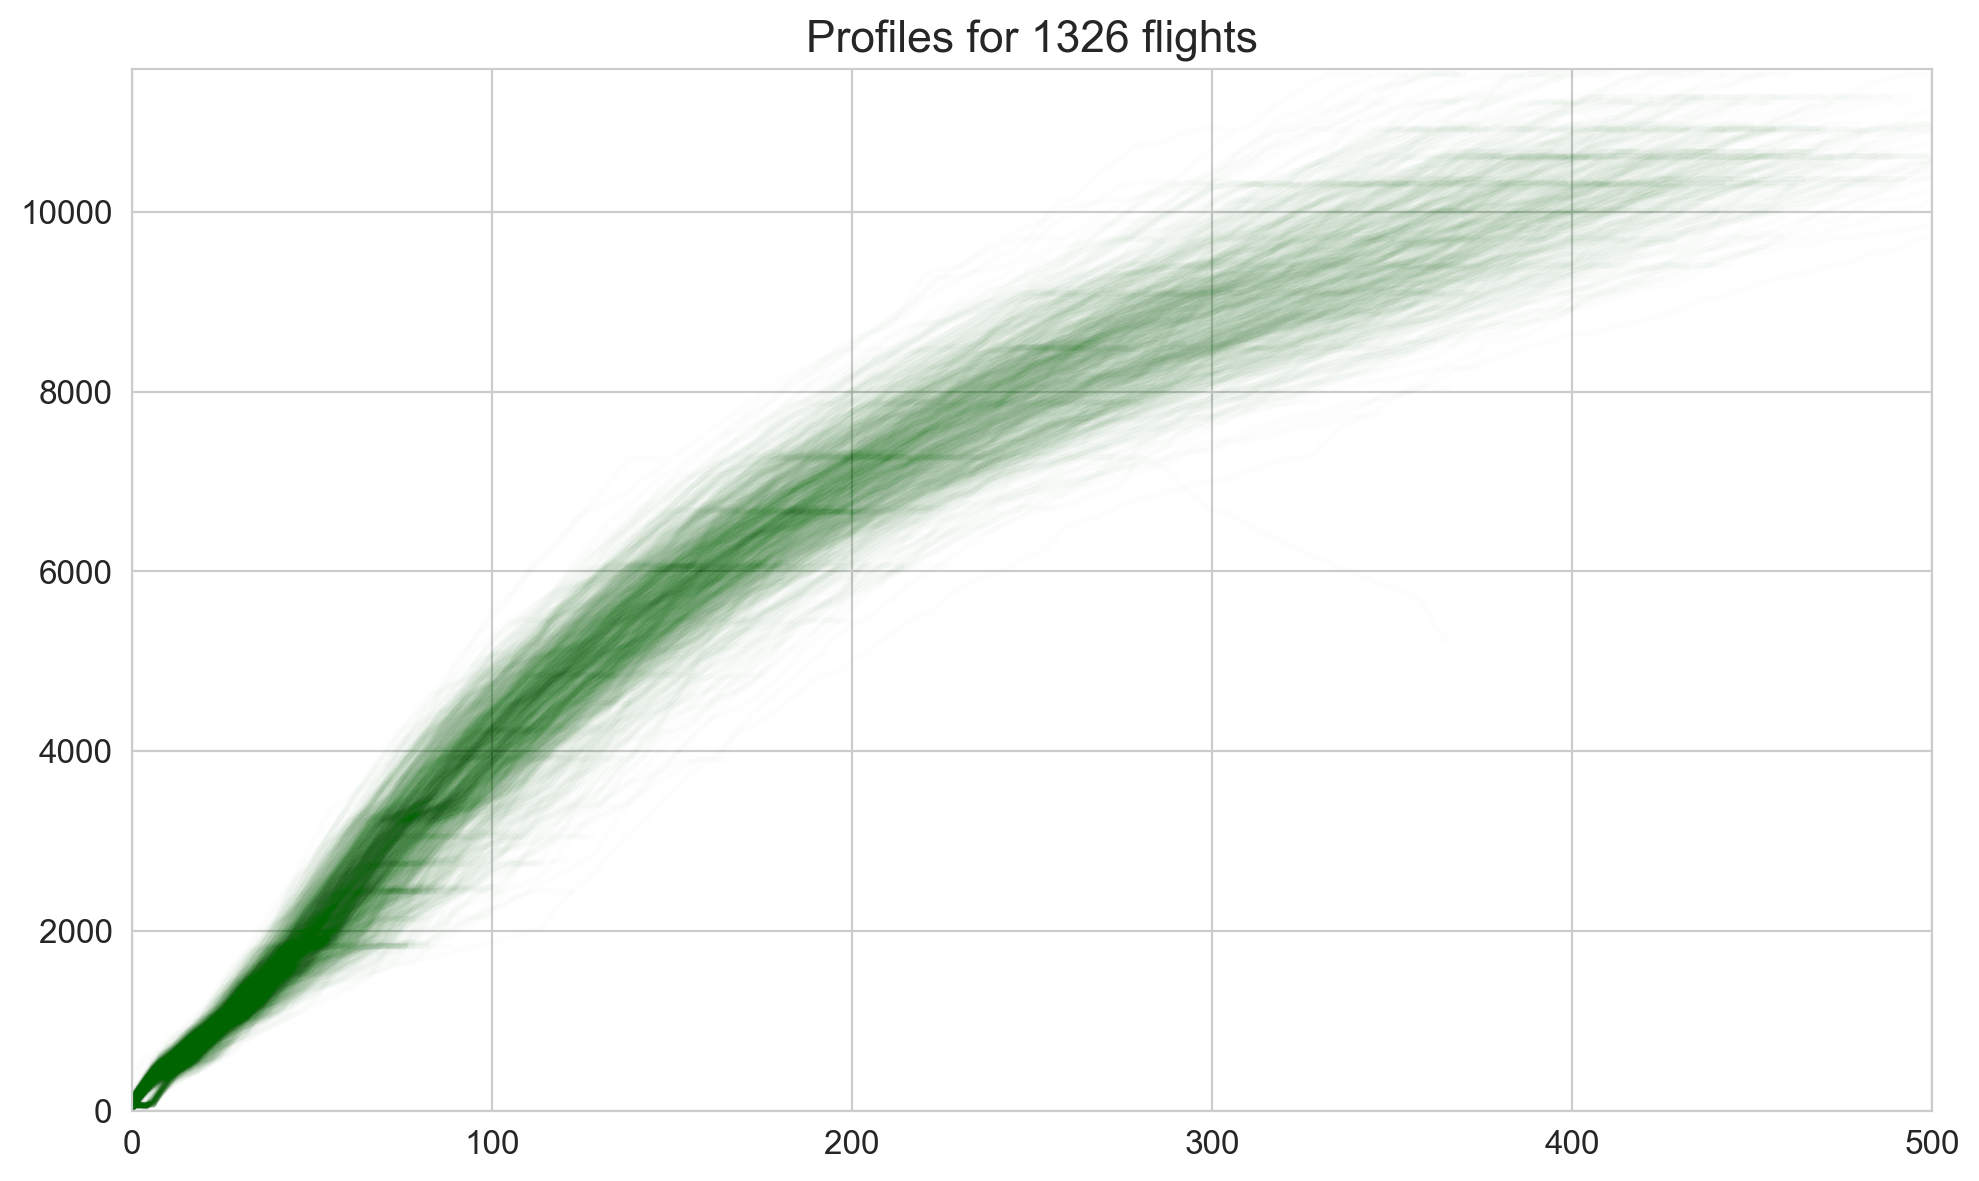

In [14]:
scene5.plot_elevation_profile(
    endalign=False, xlim=500, ylim=(0, scene5.alt_max()), alpha=0.01
)

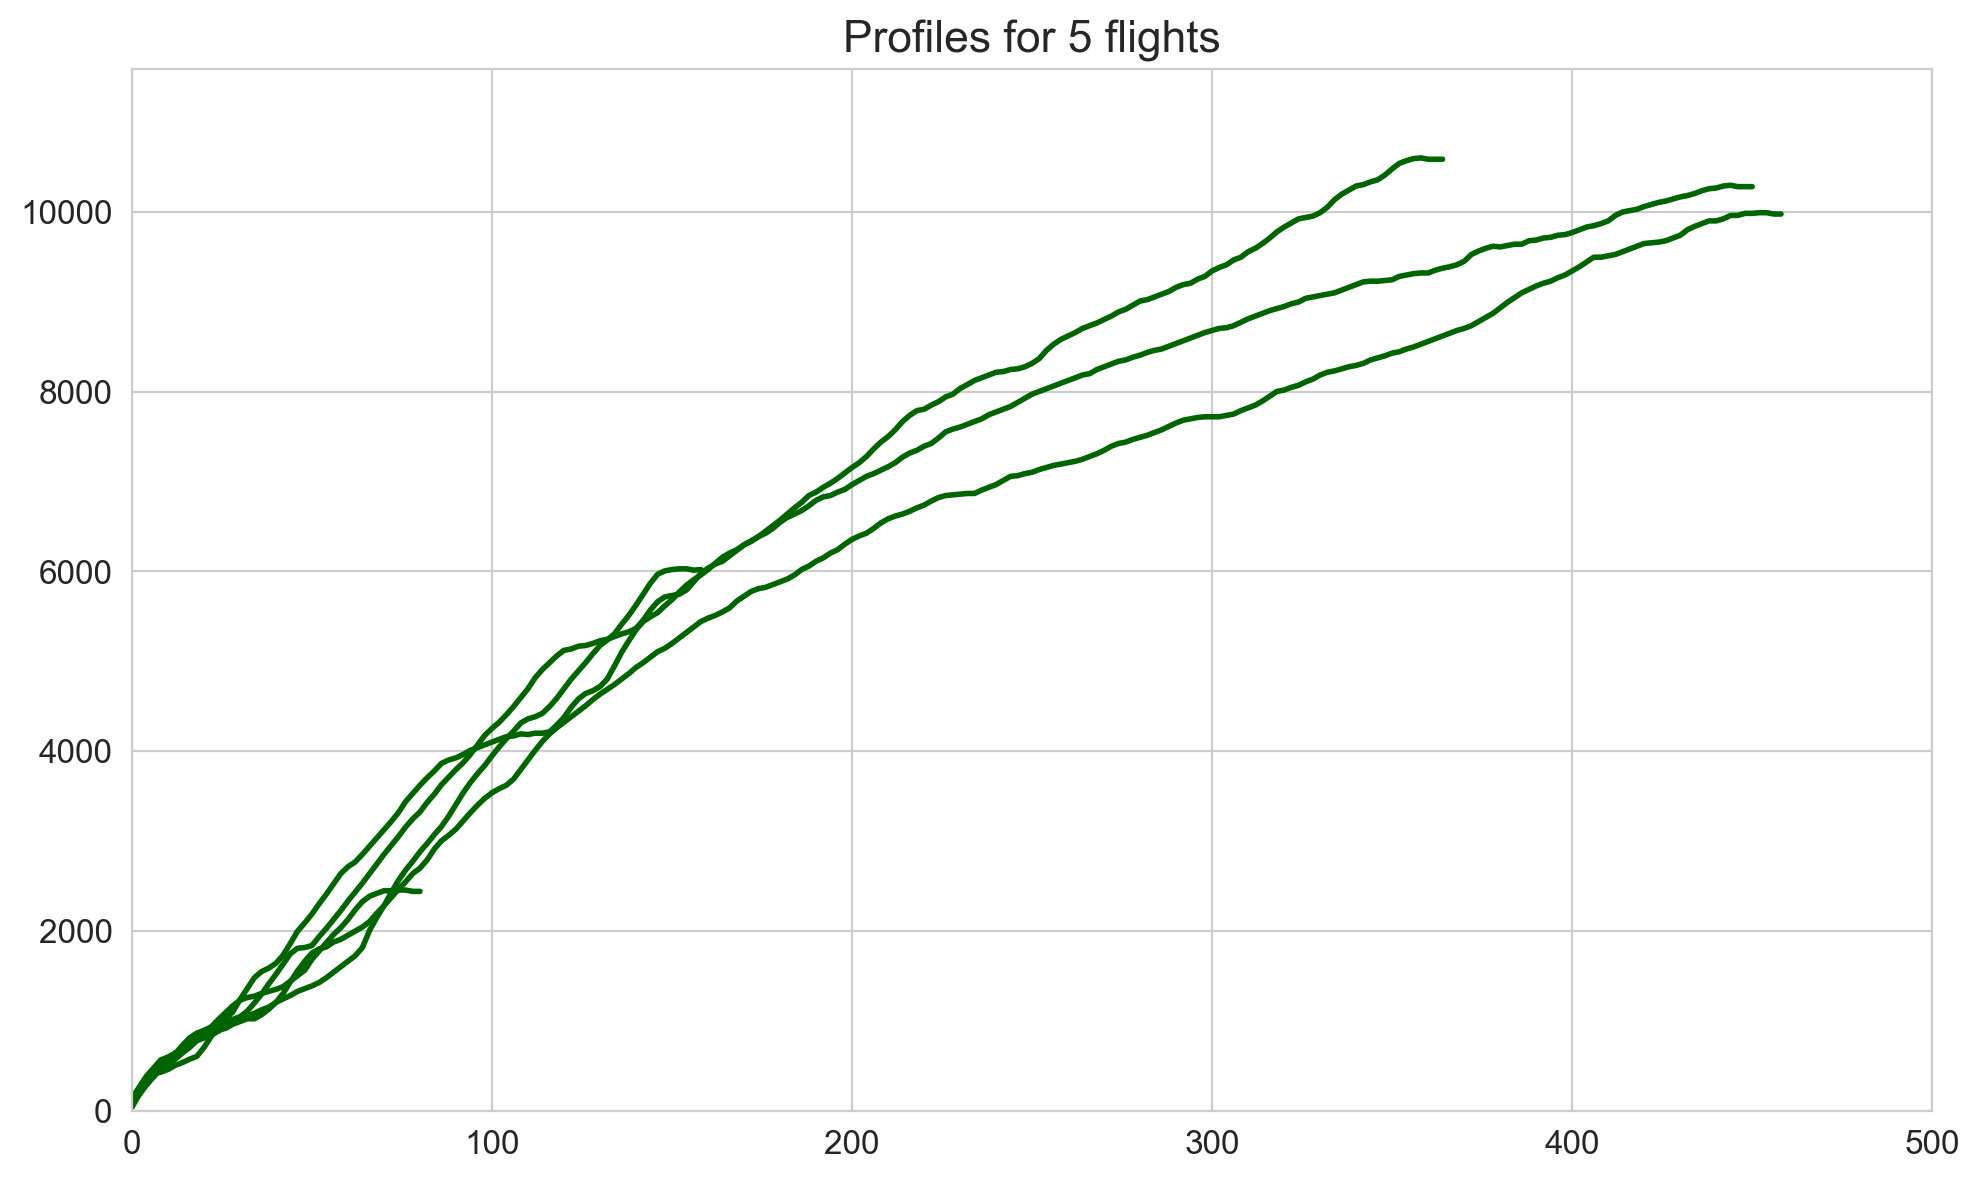

In [ ]:
Fl.plot_elevation_profile(
    scene5.flights[25:30],
    endalign=False,
    xlim=500,
    ylim=(0, scene5.alt_max()),
    alpha=1,
)

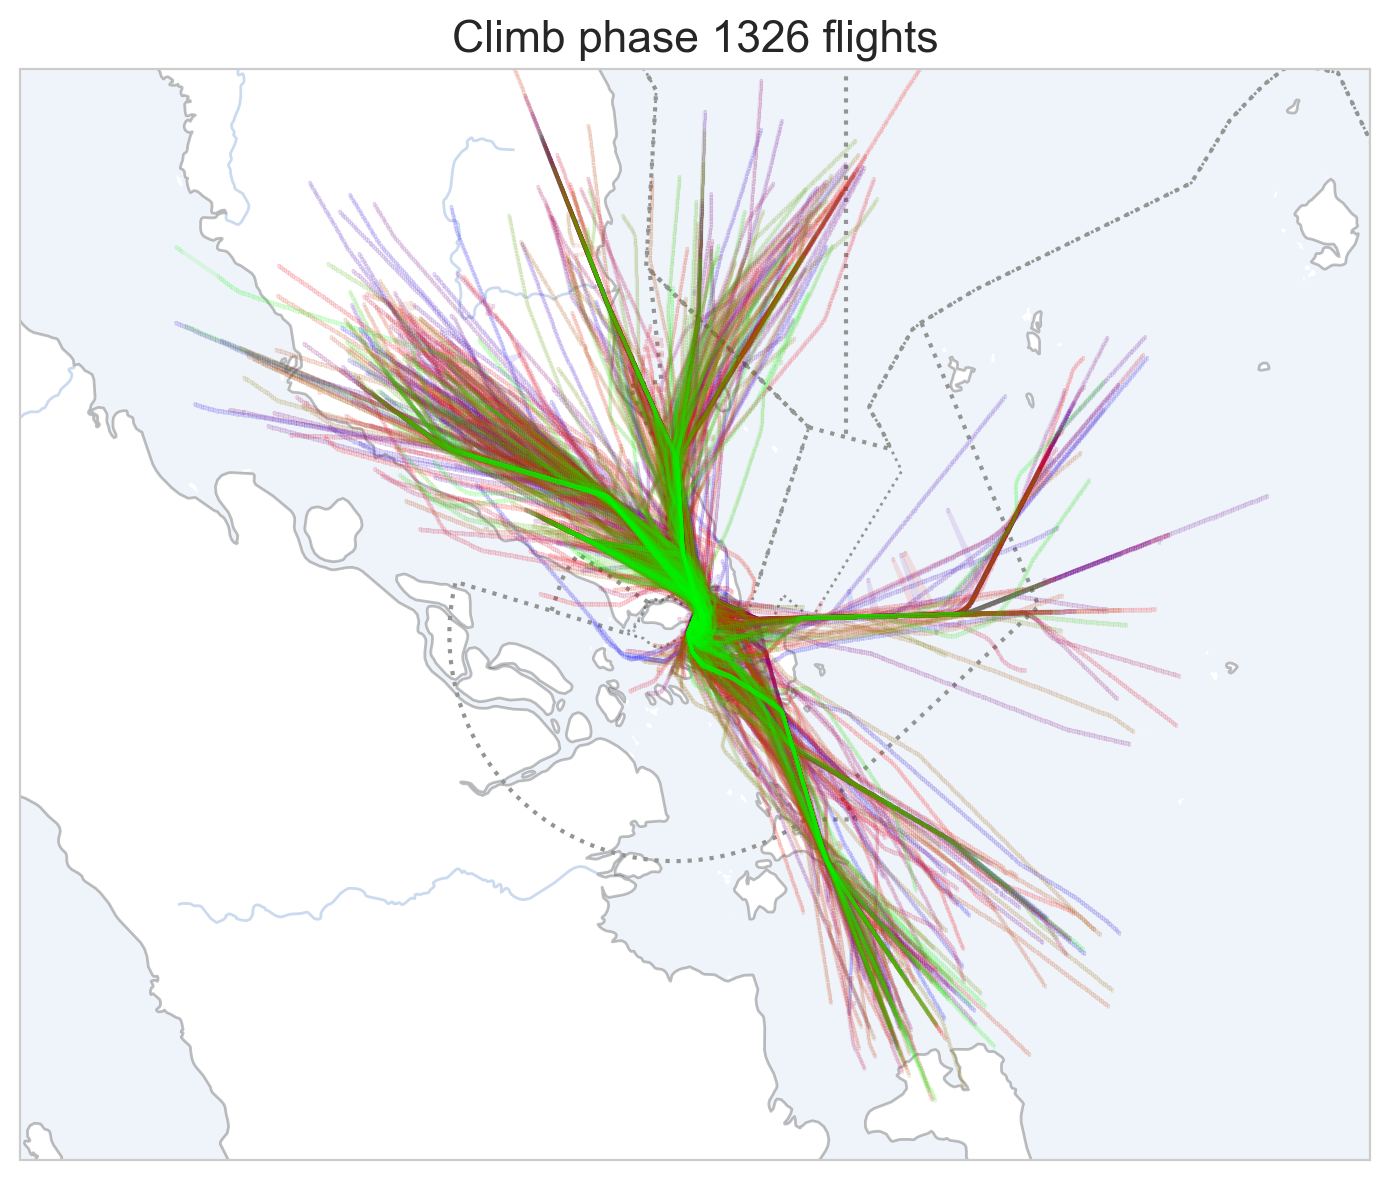

In [ ]:
scene5.plot(
    wide=500, ratio=0.8, move_east=0, move_north=0, title="Climb phase"
)

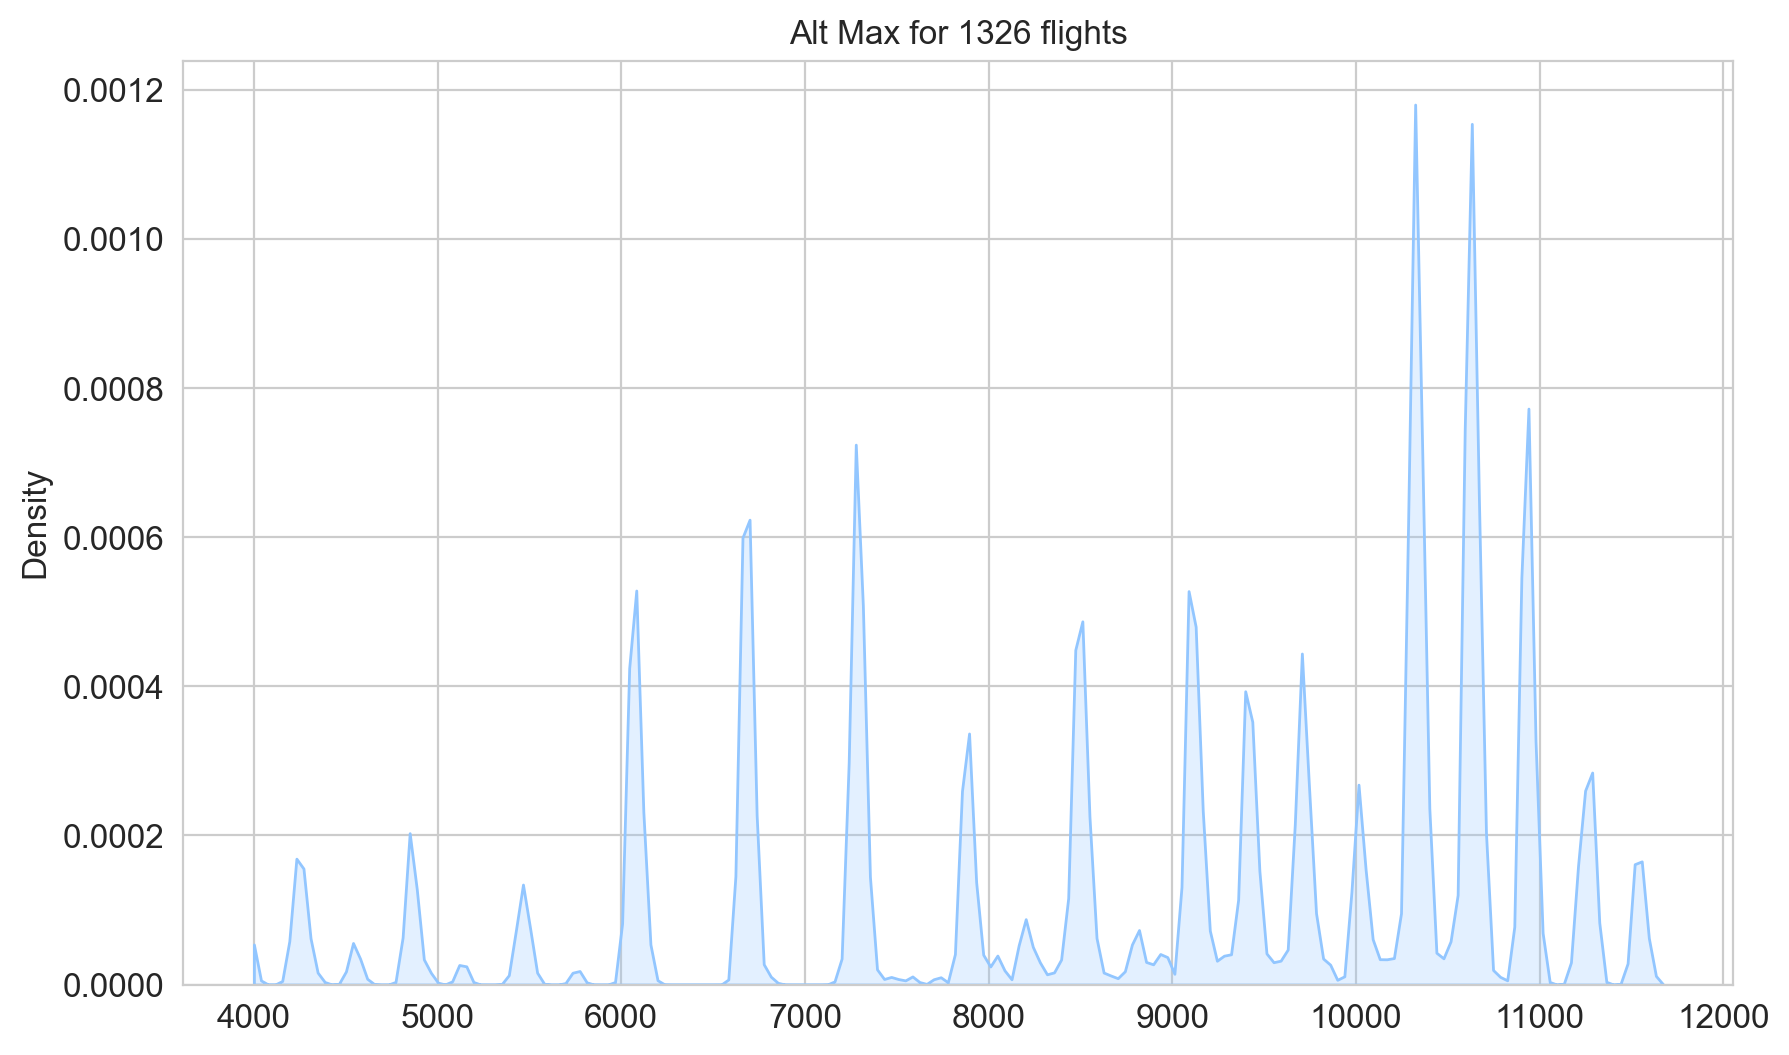

In [425]:
scene5.plot_alt_max(clip=(4000, 12000))

# Transforming data into features

### Split data

In [426]:
train, dev, test = scene5.split_train_dev_test(trainpct=80, devpct=10)
train, dev, test

(Scene with 1050 flights, copy of object (copy of object (copy of object (loaded from 24-05_full_exp.pkl, removed ['13/05/2024-19:40 AWQ261 WSSS WIII A320', '30/05/2024-11:35 AXM140 WMKK ZGOW A320', '11/05/2024-10:51 VOZ9943 YPPH WSSL B738', '30/05/2024-20:02 SIA297 WSSS NZCH A359', '31/05/2024-07:09 SIA934 WSSS WADD B78X', '31/05/2024-13:43 AXM278 WMKK WBSB A320'], removed ['13/05/2024-19:40 AWQ261 WSSS WIII A320', '30/05/2024-11:35 AXM140 WMKK ZGOW A320', '11/05/2024-10:51 VOZ9943 YPPH WSSL B738', '30/05/2024-20:02 SIA297 WSSS NZCH A359', '31/05/2024-07:09 SIA934 WSSS WADD B78X', '31/05/2024-13:43 AXM278 WMKK WBSB A320'], removed ['13/05/2024-19:40 AWQ261 WSSS WIII A320', '30/05/2024-11:35 AXM140 WMKK ZGOW A320', '11/05/2024-10:51 VOZ9943 YPPH WSSL B738', '30/05/2024-20:02 SIA297 WSSS NZCH A359', '31/05/2024-07:09 SIA934 WSSS WADD B78X', '31/05/2024-13:43 AXM278 WMKK WBSB A320'], removed ['13/05/2024-19:40 AWQ261 WSSS WIII A320', '30/05/2024-11:35 AXM140 WMKK ZGOW A320', '11/05/2024-

## Transform into features

* First, data points every 12 seconds instead of 4

* It will have ten position inputs as per Le Fablec & Alliot (1999)
  * Zi or current altitude (Altitude)
  * CFL - Zi or current distance to the CFL (toCFL)
  * The last ten altitude increments (100s in their study, 80s here - d1 to d10)
  * Hence 12 inputs in total
* The output is the next altitude  (d11)

In [427]:
def data_from_flight(flight):
    """
    Creates a block of data ready to train or test climb model
    from a flight
    """
    tracks_ = flight.tracks.copy(deep=True)

    CFL = tracks_["Altitude"].max()

    # altitude step
    tracks_["dAltitude"] = -tracks_["Altitude"].diff(-1)
    tracks_["dAltitude"].iloc[-1] = 0

    # distance to CFL
    tracks_["toCFL"] = CFL - tracks_["Altitude"]

    # Altitude steps
    tracks_["d10"] = tracks_["dAltitude"]
    tracks_["d9"] = tracks_["dAltitude"].shift(periods=1)
    tracks_["d8"] = tracks_["dAltitude"].shift(periods=2)
    tracks_["d7"] = tracks_["dAltitude"].shift(periods=3)
    tracks_["d6"] = tracks_["dAltitude"].shift(periods=4)
    tracks_["d5"] = tracks_["dAltitude"].shift(periods=5)
    tracks_["d4"] = tracks_["dAltitude"].shift(periods=6)
    tracks_["d3"] = tracks_["dAltitude"].shift(periods=7)
    tracks_["d2"] = tracks_["dAltitude"].shift(periods=8)
    tracks_["d1"] = tracks_["dAltitude"].shift(periods=9)
    tracks_["d11"] = tracks_["dAltitude"].shift(periods=-1)

    tracks_.drop(
        [
            "Time",
            "Latitude",
            "Longitude",
            "Vx",
            "Vy",
            "ClosestFix",
            "cos_b_1",
            "cos_b_2",
            "c_1",
            "c_2",
            "d_1",
            "d_2",
            "l_1_l",
            "l_1_t",
            "l_2_l",
            "l_2_t",
            "dAltitude",
            "Unix",
            "theta",
            "alpha_1",
            "b_1",
            "alpha_2",
            "b_2",
            "c_min",
        ],
        axis=1,
        inplace=True,
        errors="ignore",
    )
    tracks_.dropna(axis=0, inplace=True)
    return tracks_


def filter_for_gaps(tracks):
    for i in [
        "d10",
        "d9",
        "d8",
        "d7",
        "d6",
        "d5",
        "d4",
        "d3",
        "d2",
        "d1",
        "d11",
    ]:
        tracks.drop(tracks[tracks[i] > 150].index, inplace=True)
    return tracks


def data_from_scene(scene):
    """
    Creates a block of data ready to train or test the climb model
    from a list of flights
    """
    full_data = pd.DataFrame(columns=[])
    for flight_ in scene.flights:
        full_data = pd.concat(
            [filter_for_gaps(data_from_flight(flight_)), full_data],
            axis=0,
            ignore_index=True,
        )
    return full_data

In [428]:
train_features = data_from_scene(train)
dev_features = data_from_scene(dev)
test_features = data_from_scene(test)

train_features.shape, dev_features.shape, test_features.shape

((134892, 13), (17124, 13), (18429, 13))

In [429]:
dev_features

Altitude    toCFL   d10    d9    d8    d7    d6    d5    d4     d3  \
0        861.06 9,464.04 38.10 60.96 60.96 83.82 83.82 91.44 99.06 121.92   
1        899.16 9,425.94 38.10 38.10 60.96 60.96 83.82 83.82 91.44  99.06   
2        937.26 9,387.84 30.48 38.10 38.10 60.96 60.96 83.82 83.82  91.44   
3        967.74 9,357.36 30.48 30.48 38.10 38.10 60.96 60.96 83.82  83.82   
4        998.22 9,326.88 15.24 30.48 30.48 38.10 38.10 60.96 60.96  83.82   
...         ...      ...   ...   ...   ...   ...   ...   ...   ...    ...   
17119  9,677.40    22.86 22.86  7.62 30.48 30.48 30.48 45.72 30.48  45.72   
17120  9,700.26     0.00 -0.00 22.86  7.62 30.48 30.48 30.48 45.72  30.48   
17121  9,700.26     0.00 -7.62 -0.00 22.86  7.62 30.48 30.48 30.48  45.72   
17122  9,692.64     7.62 -0.00 -7.62 -0.00 22.86  7.62 30.48 30.48  30.48   
17123  9,692.64     7.62 -0.00 -0.00 -7.62 -0.00 22.86  7.62 30.48  30.48   

          d2     d1   d11  
0      99.06  83.82 38.10  
1     121.92  99.06 30.48  
2      99.06 121.92 30.48  
3      91.44  99.06 15.24  
4      83.82  91.44 45.72  
...      ...    ...   ...  
17119  53.34  38.10 -0.00  
17120  45.72  53.34 -7.62  
17121  30.48  45.72 -0.00  
17122  45.72  30.48 -0.00  
17123  30.48  45.72  0.00  

[17124 rows x 13 columns]

## Scale the data

In [430]:
from sklearn import preprocessing

# Re-usable scaler
scaler = preprocessing.MinMaxScaler()

train_X = scaler.fit_transform(train_features.to_numpy()[:, :-1])
train_y = train_features["d11"].to_numpy()[:]

dev_X = scaler.transform(dev_features.to_numpy()[:, :-1])
dev_y = dev_features["d11"].to_numpy()[:]

test_X = scaler.transform(test_features.to_numpy()[:, :-1])
test_y = test_features["d11"].to_numpy()[:]

train_X.shape, train_y.shape, dev_X.shape, dev_y.shape, test_X.shape, test_y.shape

((134892, 12), (134892,), (17124, 12), (17124,), (18429, 12), (18429,))

In [431]:
train_X[0]

array([0.03005464, 0.58815331, 0.60526316, 0.65789474, 0.81578947,
       0.81818182, 0.57575758, 0.60606061, 0.57575758, 0.81818182,
       0.90787913, 0.90176988])

## Into tensor, datasets & dataloaders

In [455]:
train_dataset = TensorDataset(
    torch.tensor(train_X, dtype=torch.float),
    torch.tensor(train_y, dtype=torch.float),
)
train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=16, shuffle=False
)

dev_dataset = TensorDataset(
    torch.tensor(dev_X, dtype=torch.float),
    torch.tensor(dev_y, dtype=torch.float),
)
dev_dataloader = DataLoader(dev_dataset, batch_size=16, shuffle=False)

test_dataset = TensorDataset(
    torch.tensor(test_X, dtype=torch.float),
    torch.tensor(test_y, dtype=torch.float),
)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## ML Model

### Creation of climber model

In [ ]:
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

DEVICE = "cpu"
DEVICE

In [461]:
class Climber(nn.Module):

    def __init__(self, num_positions=10, device="cpu"):
        super().__init__()
        self.num_positions = num_positions
        self.hidden1 = nn.Linear(
            in_features=num_positions + 2,
            out_features=num_positions + 2,
            device=device,
        )
        self.relu = nn.ReLU()
        self.hidden2 = nn.Linear(
            in_features=(num_positions + 2) * 2,
            out_features=num_positions + 2,
            device=device,
        )
        self.output = nn.Linear(
            in_features=num_positions + 2, out_features=1, device=device
        )

    def forward(self, X):
        z = self.hidden1(X)
        z = self.relu(z)
        z = torch.cat([z, X], axis=-1)
        z = self.hidden2(z)
        z = self.relu(z)
        o = self.output(z)
        return o


model = Climber(num_positions=10, device=device)
model.to(device)

Climber(
  (hidden1): Linear(in_features=12, out_features=12, bias=True)
  (relu): ReLU()
  (hidden2): Linear(in_features=24, out_features=12, bias=True)
  (output): Linear(in_features=12, out_features=1, bias=True)
)

# Training the model

In [ ]:
# Global variables to allow interrupting the training

global_epoch_number = 0  # will keep the epoch number within runs
best_dev_loss = 1_000_000.0  # will keep record of best dev loss

### Epoch Training loop function

In [500]:
def train_one_epoch(epoch_index, loss_fn, optimizer, writer):
    """
    Implementation of one epoch train
    """
    running_loss = 0.0
    last_loss = 0.0

    model.train()
    for i, data in enumerate(train_dataloader):  # could be iter()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000  # loss per batch
            print(f"  batch {i + 1} loss: {round(last_loss,1)}")
            tb_x = epoch_index * len(train_dataloader) + i + 1
            writer.add_scalar("Loss/train", last_loss, tb_x)
            running_loss = 0.0

    return last_loss

### Main Training Loop function

In [516]:
def train_model(
    epochs,
    loss_fn,
    optimizer,
    writer,
    model_path,
    global_epoch_number,
    best_dev_loss,
):
    """
    Implements training loop
    """

    for _ in range(epochs):
        print(f"EPOCH {global_epoch_number+1}:")

        avg_train_loss = train_one_epoch(
            epoch_index=global_epoch_number,
            loss_fn=loss_fn,
            optimizer=optimizer,
            writer=writer,
        )

        running_dev_loss = 0.0
        model.eval()
        with torch.no_grad():
            for i, vdata in enumerate(dev_dataloader):
                dev_inputs, dev_labels = vdata
                dev_inputs = dev_inputs.to(device)
                dev_labels = dev_labels.to(device)
                dev_outputs = model(dev_inputs)
                dev_loss = loss_fn(dev_outputs, dev_labels)
                running_dev_loss += dev_loss

        avg_dev_loss = running_dev_loss / (i + 1)
        print(
            f"LOSS train {round(avg_train_loss,1)} valid {torch.round(avg_dev_loss)}"
        )

        writer.add_scalars(
            "Training vs. Validation Loss",
            {
                "Training": avg_train_loss,
                "Validation": avg_dev_loss,
            },
            global_epoch_number + 1,
        )
        writer.add_scalars(
            "Learning Rate",
            {
                "LR": optimizer.param_groups[0]["lr"],
            },
            global_epoch_number + 1,
        )
        writer.flush()

        # Track best performance, and save the model's state
        if avg_dev_loss < best_dev_loss:
            best_dev_loss = avg_dev_loss
            torch.save(
                model.state_dict(), model_path + f"_{global_epoch_number}"
            )

        global_epoch_number += 1

### Setting up Tensorboard run

In [ ]:
# Only for new runs!
# Separated so the run can be extended manually, do not execute again on same run

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter("runs/climber_{}".format(timestamp))
model_path = f"save/climber_{timestamp}"

## Training execution

### Using MSELoss and Adam optimizer

Learning rate found experimentally to be optimal at 0.001 and then reduced for fine tuning

In [639]:
loss_fn = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

### We execute the training here

In [649]:
train_model(
    epochs=10000,
    loss_fn=loss_fn,
    optimizer=optimizer,
    writer=writer,
    model_path=model_path,
    global_epoch_number=global_epoch_number,
    best_dev_loss=best_dev_loss,
)

EPOCH 2033:
  batch 1000 loss: 716.6
  batch 2000 loss: 656.4
  batch 3000 loss: 620.8
  batch 4000 loss: 656.6
  batch 5000 loss: 674.2
  batch 6000 loss: 634.6
  batch 7000 loss: 643.4
  batch 8000 loss: 618.7
LOSS train 618.7 valid 613.0
EPOCH 2034:
  batch 1000 loss: 716.9
  batch 2000 loss: 656.5
  batch 3000 loss: 620.7
  batch 4000 loss: 656.5
  batch 5000 loss: 674.1
  batch 6000 loss: 634.7
  batch 7000 loss: 643.4
  batch 8000 loss: 618.7
LOSS train 618.7 valid 613.0
EPOCH 2035:
  batch 1000 loss: 717.0
  batch 2000 loss: 656.5
  batch 3000 loss: 620.7
  batch 4000 loss: 656.5
  batch 5000 loss: 674.1
  batch 6000 loss: 634.7
  batch 7000 loss: 643.3
  batch 8000 loss: 618.7
LOSS train 618.7 valid 613.0
EPOCH 2036:
  batch 1000 loss: 717.0
  batch 2000 loss: 656.5
  batch 3000 loss: 620.7
  batch 4000 loss: 656.4
  batch 5000 loss: 674.1
  batch 6000 loss: 634.7
  batch 7000 loss: 643.3
  batch 8000 loss: 618.7
LOSS train 618.7 valid 613.0
EPOCH 2037:
  batch 1000 loss: 717.0

KeyboardInterrupt: 

# Flight climb prediction using the model

In [ ]:
def sample_from_minutes(minutes):
    # sample  = time/8 - 19/2
    return int(round(minutes * 60 / 8 + 19 / 2))


def predict_a_flight(model, flight, start_prediction_sample, up_to_CFL=True):
    """
    Taking a flight and a sample, predicts up to CFL (if True)
    or next eight minutes

    Sample number mapped to time:
        28 : 5 min
        65 : 10 min
        103 : 15 min
        141 : 20 min
        178 : 25 min
    """
    # Find the actual time from the sample number
    time_cursor = flight.tracks.to_numpy()[start_prediction_sample, 0]

    # Processes the flight data
    # get the content in one position and remove d11
    # nine is required as correction because of tracks
    # removed at start
    start_point = data_from_flight(flight).to_numpy()[
        start_prediction_sample - 9 : start_prediction_sample - 9 + 1,
        :-1,
    ]

    # Unpacking data in start point
    # note numpy array columns are, in this order:
    # "Altitude","toCFL","d10","d9","d8","d7","d6","d5",
    # "d4","d3","d2","d1","d11" (last to remove)
    altitude = start_point[0, 0]
    toCFL = start_point[0, 1]
    d10tod1 = start_point[0, 2:12]
    current_point = start_point
    time = [time_cursor]
    time_cursor_initial = time_cursor
    pred_alt = [altitude]

    # Do the prediction loop
    while (up_to_CFL and toCFL > 10) or (
        not up_to_CFL and time_cursor <= time_cursor_initial + 122
    ):
        # transform and make a prediction
        transformed_point = scaler.transform(current_point)
        delta = model(torch.Tensor(transformed_point)).item()

        # update position for next prediction
        time_cursor += 2
        altitude += delta
        toCFL -= delta

        # update the prediction data
        d10tod1 = np.insert(d10tod1, 0, delta)[0:10]
        current_point = np.insert(d10tod1, 0, [altitude, toCFL])
        current_point = current_point.reshape(1, 12)

        # build the response
        time.append(time_cursor)
        pred_alt.append(altitude)

    return time, pred_alt

### Sampling predictions on the test set


Sample 1 from test dataset


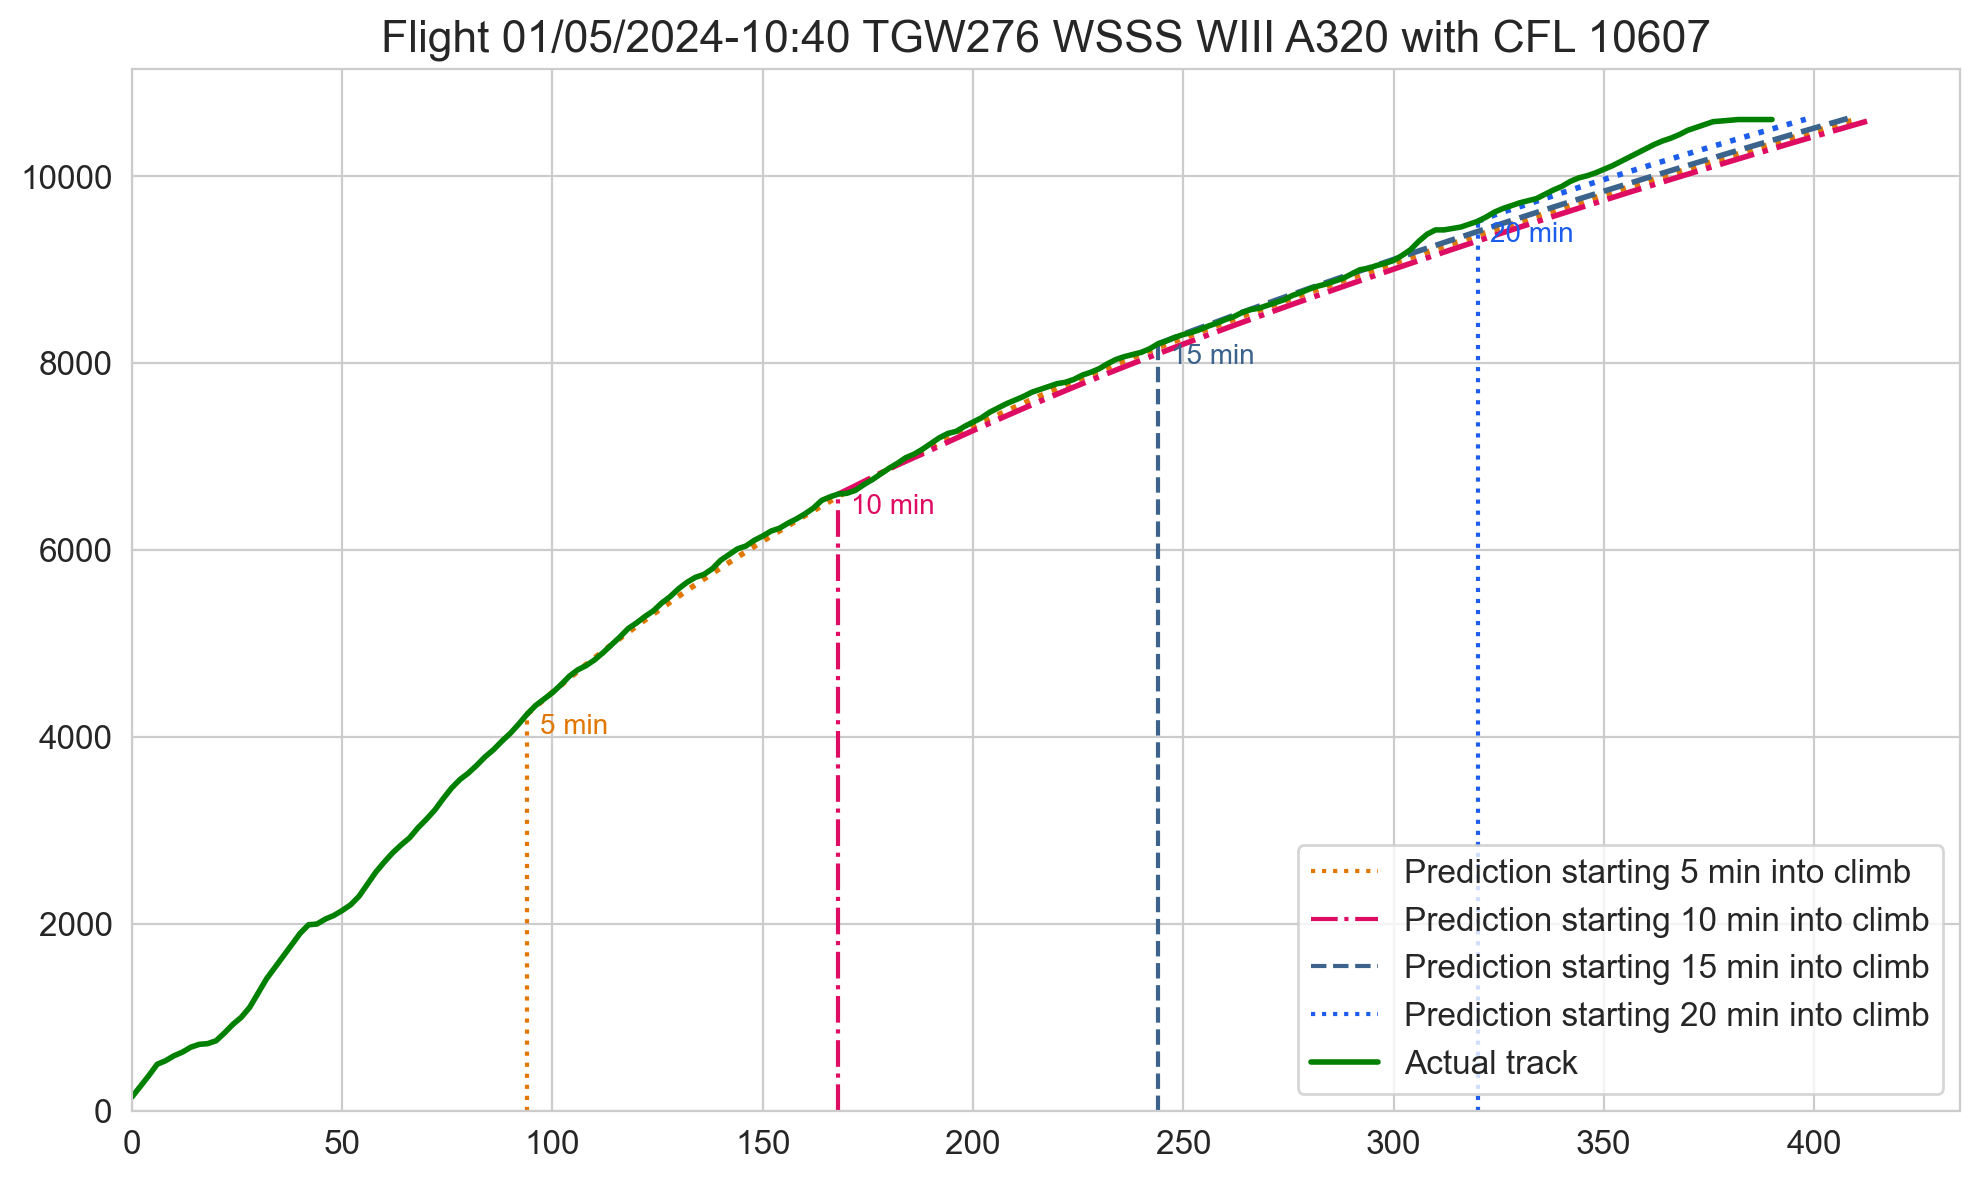


Sample 3 from test dataset


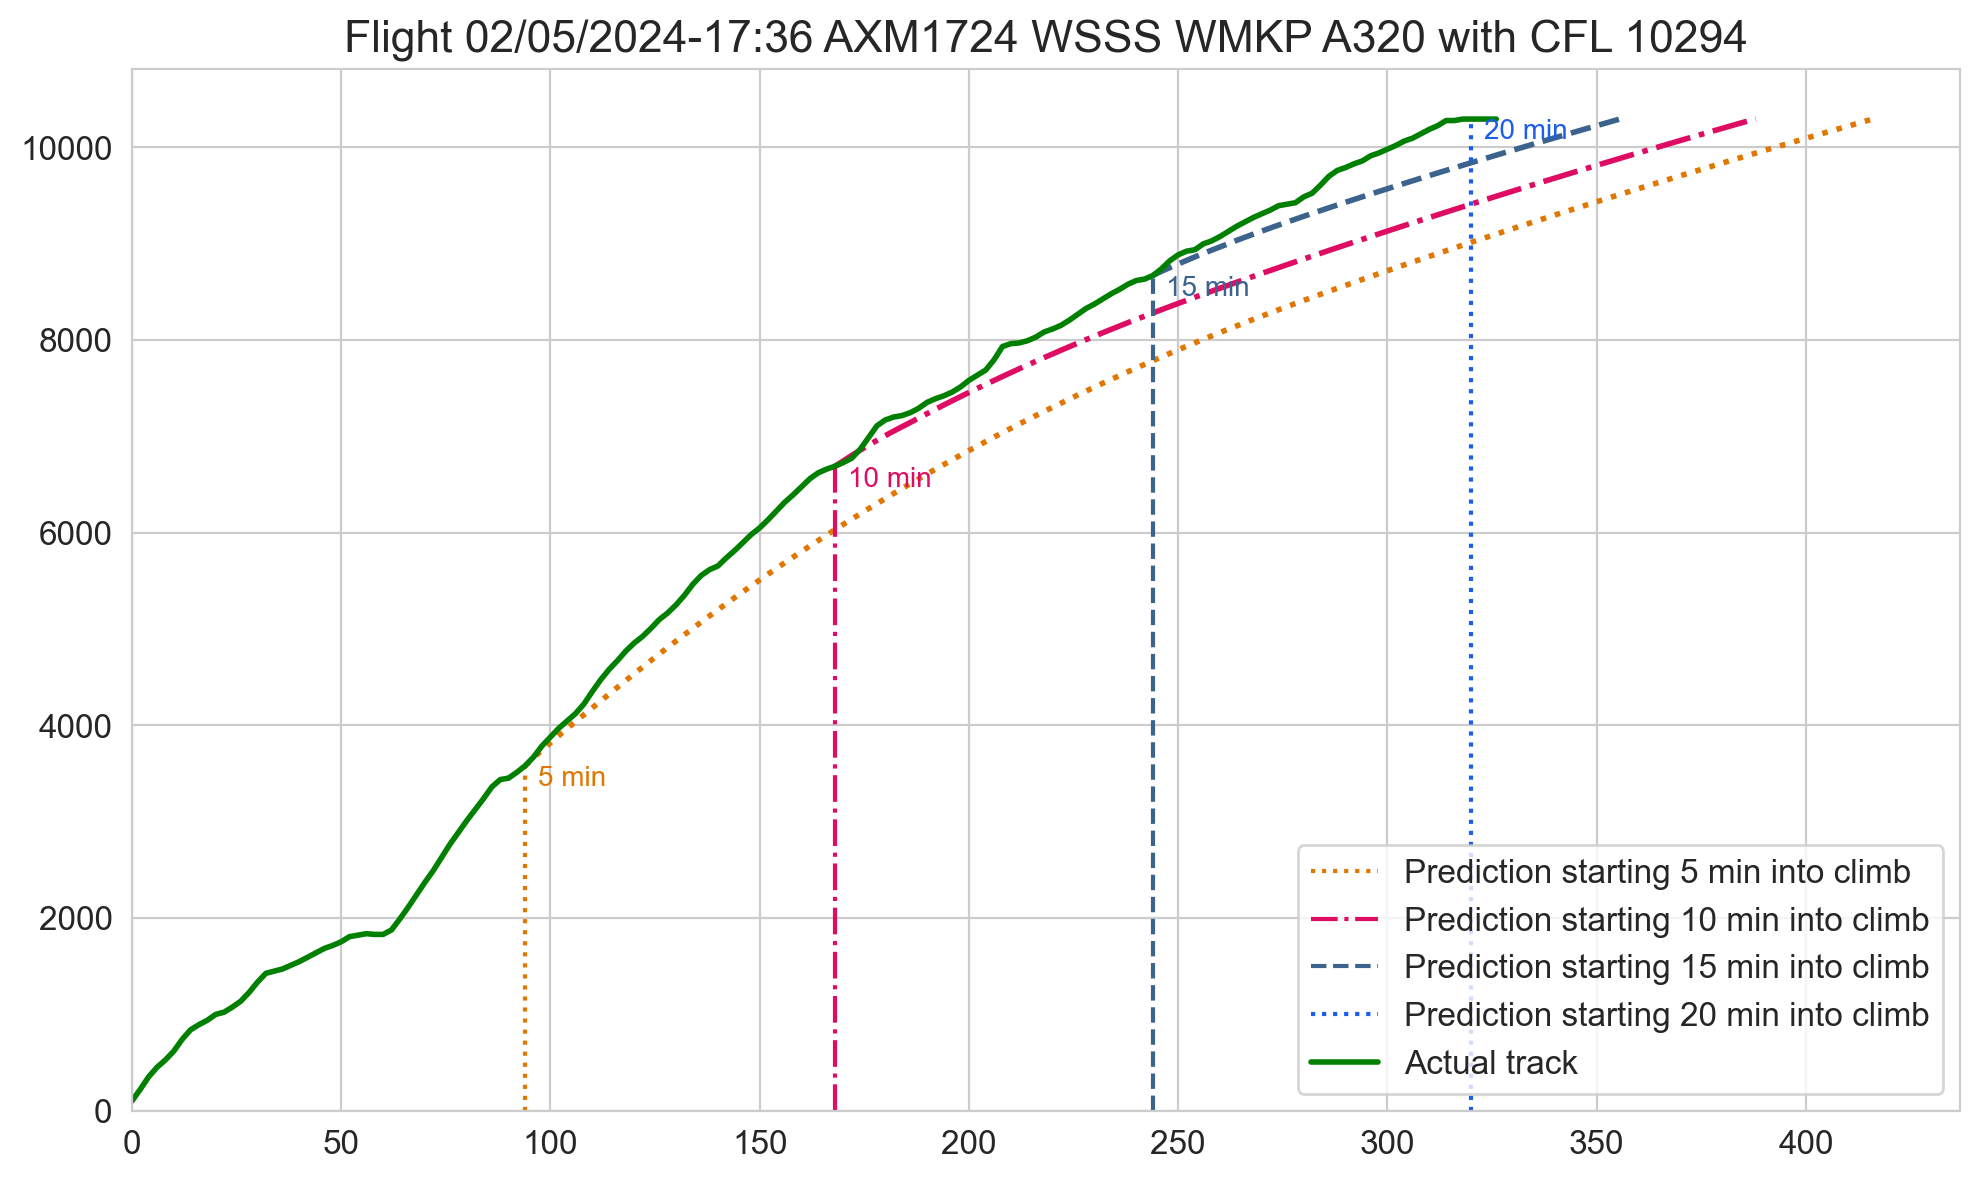


Sample 4 from test dataset


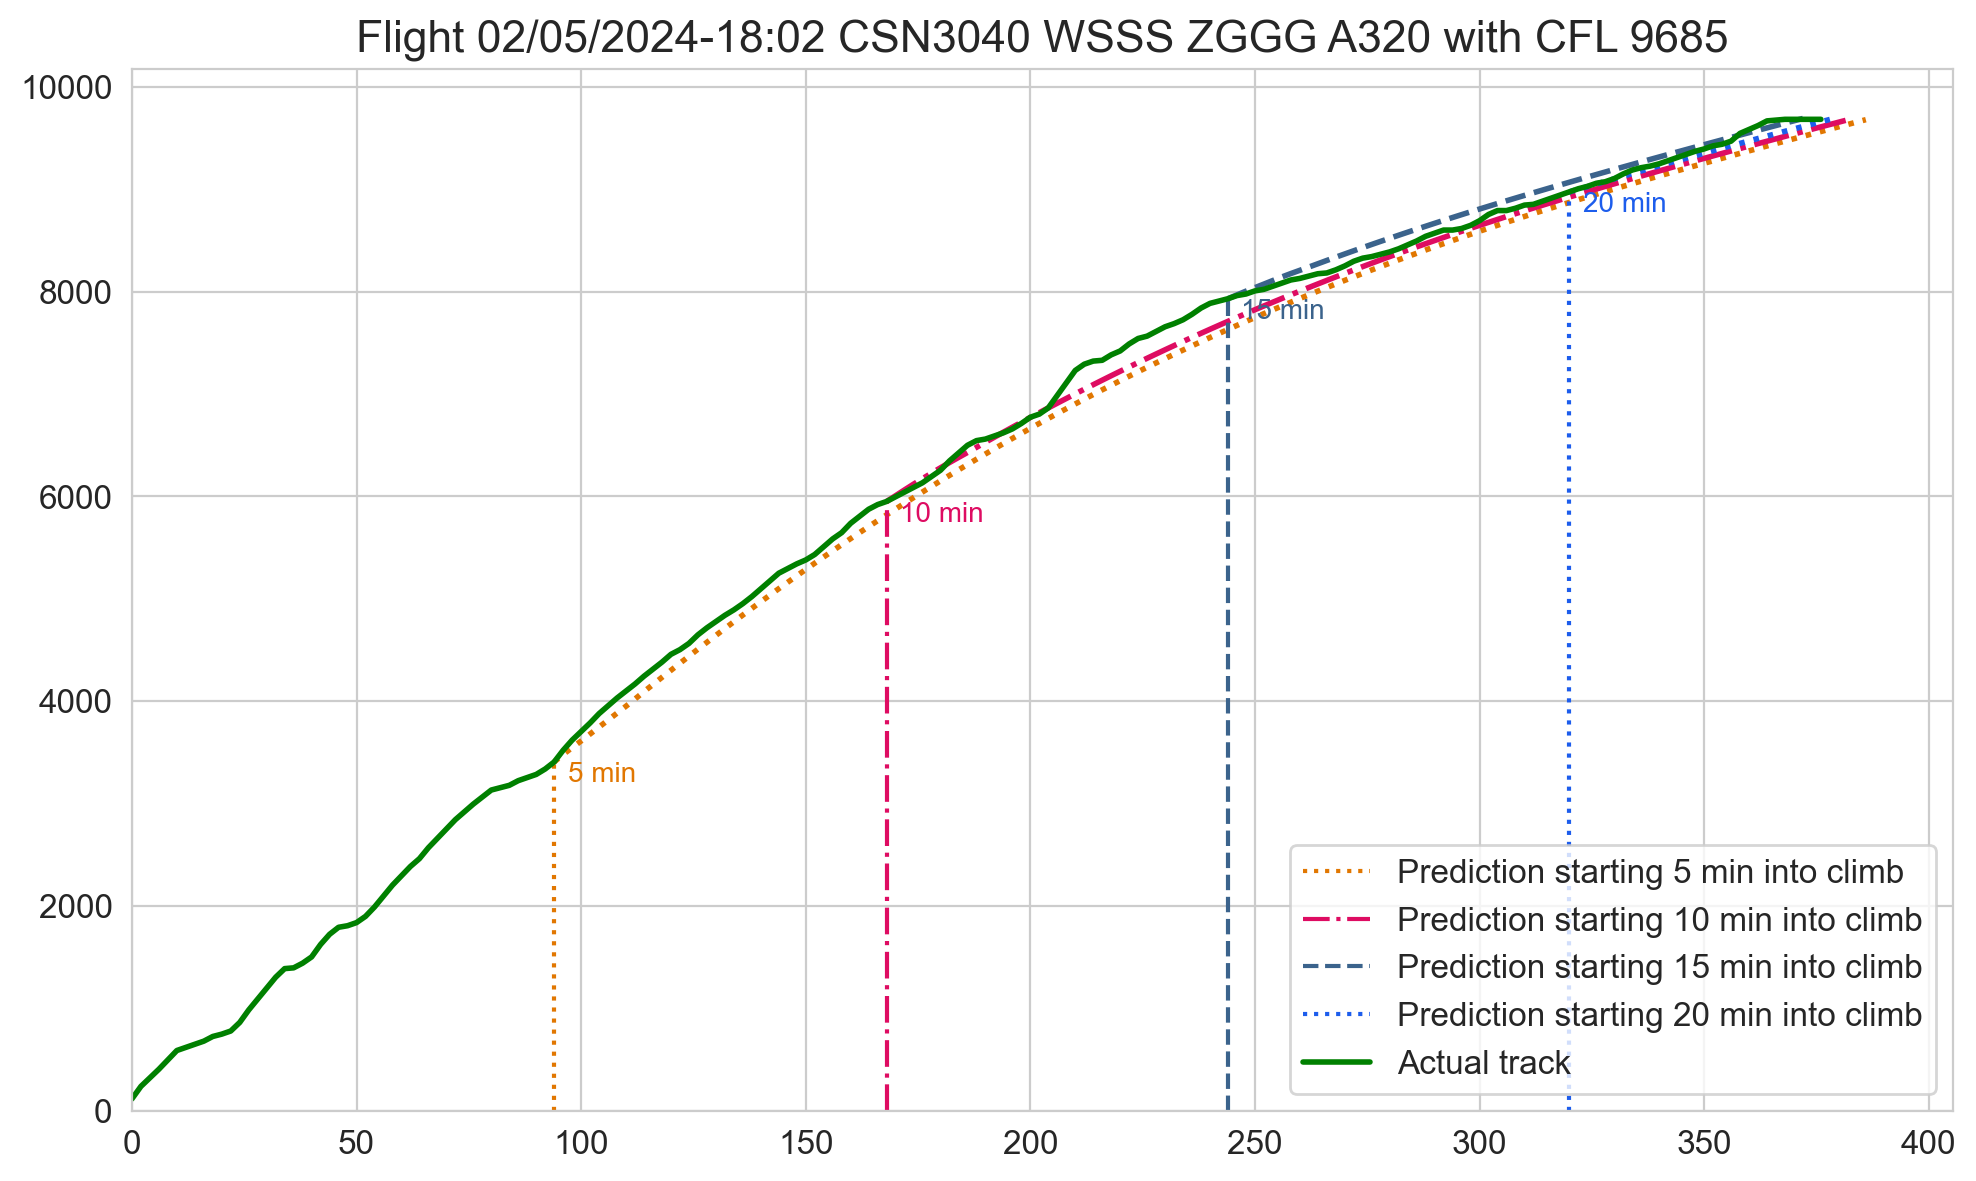


Sample 5 from test dataset


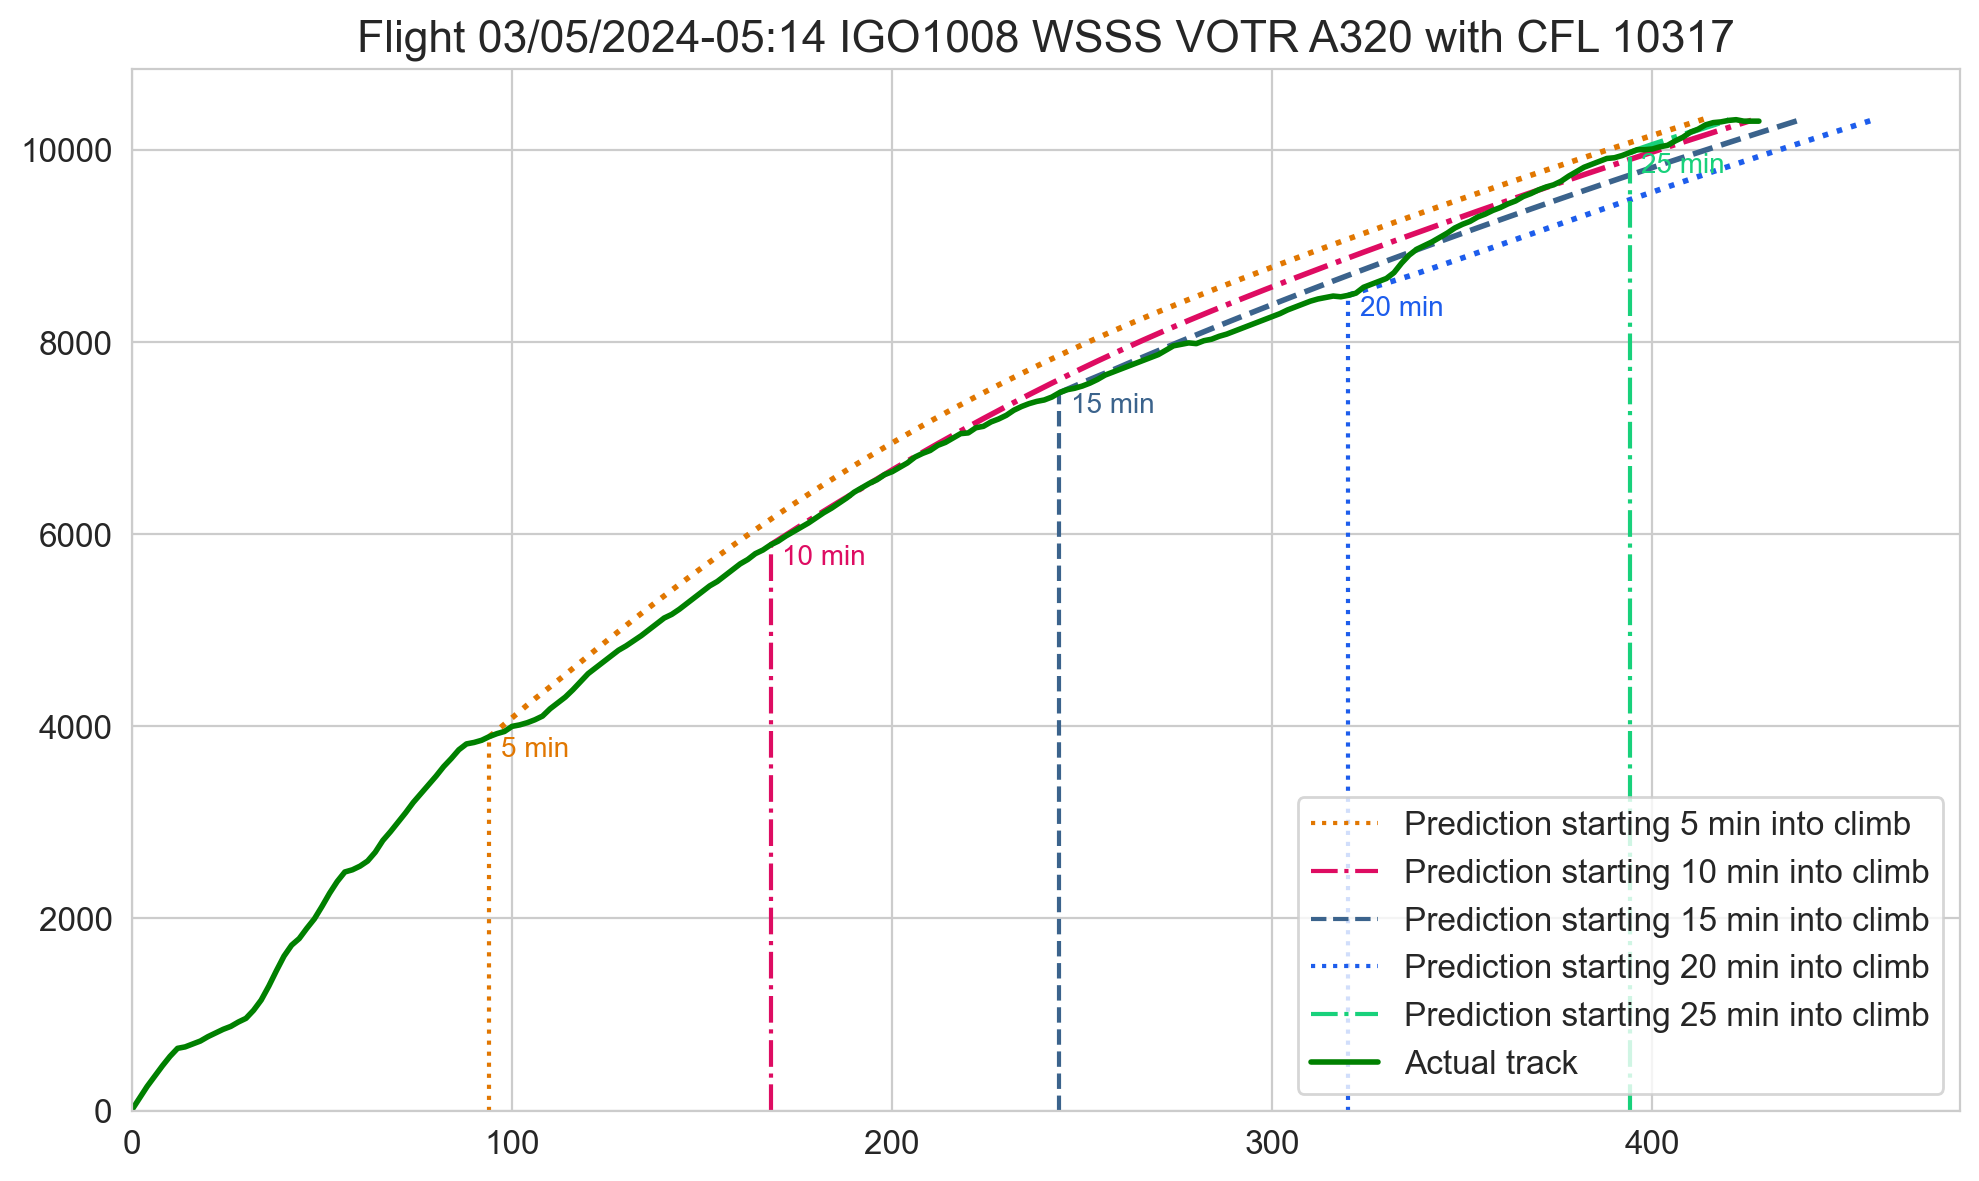


Sample 7 from test dataset


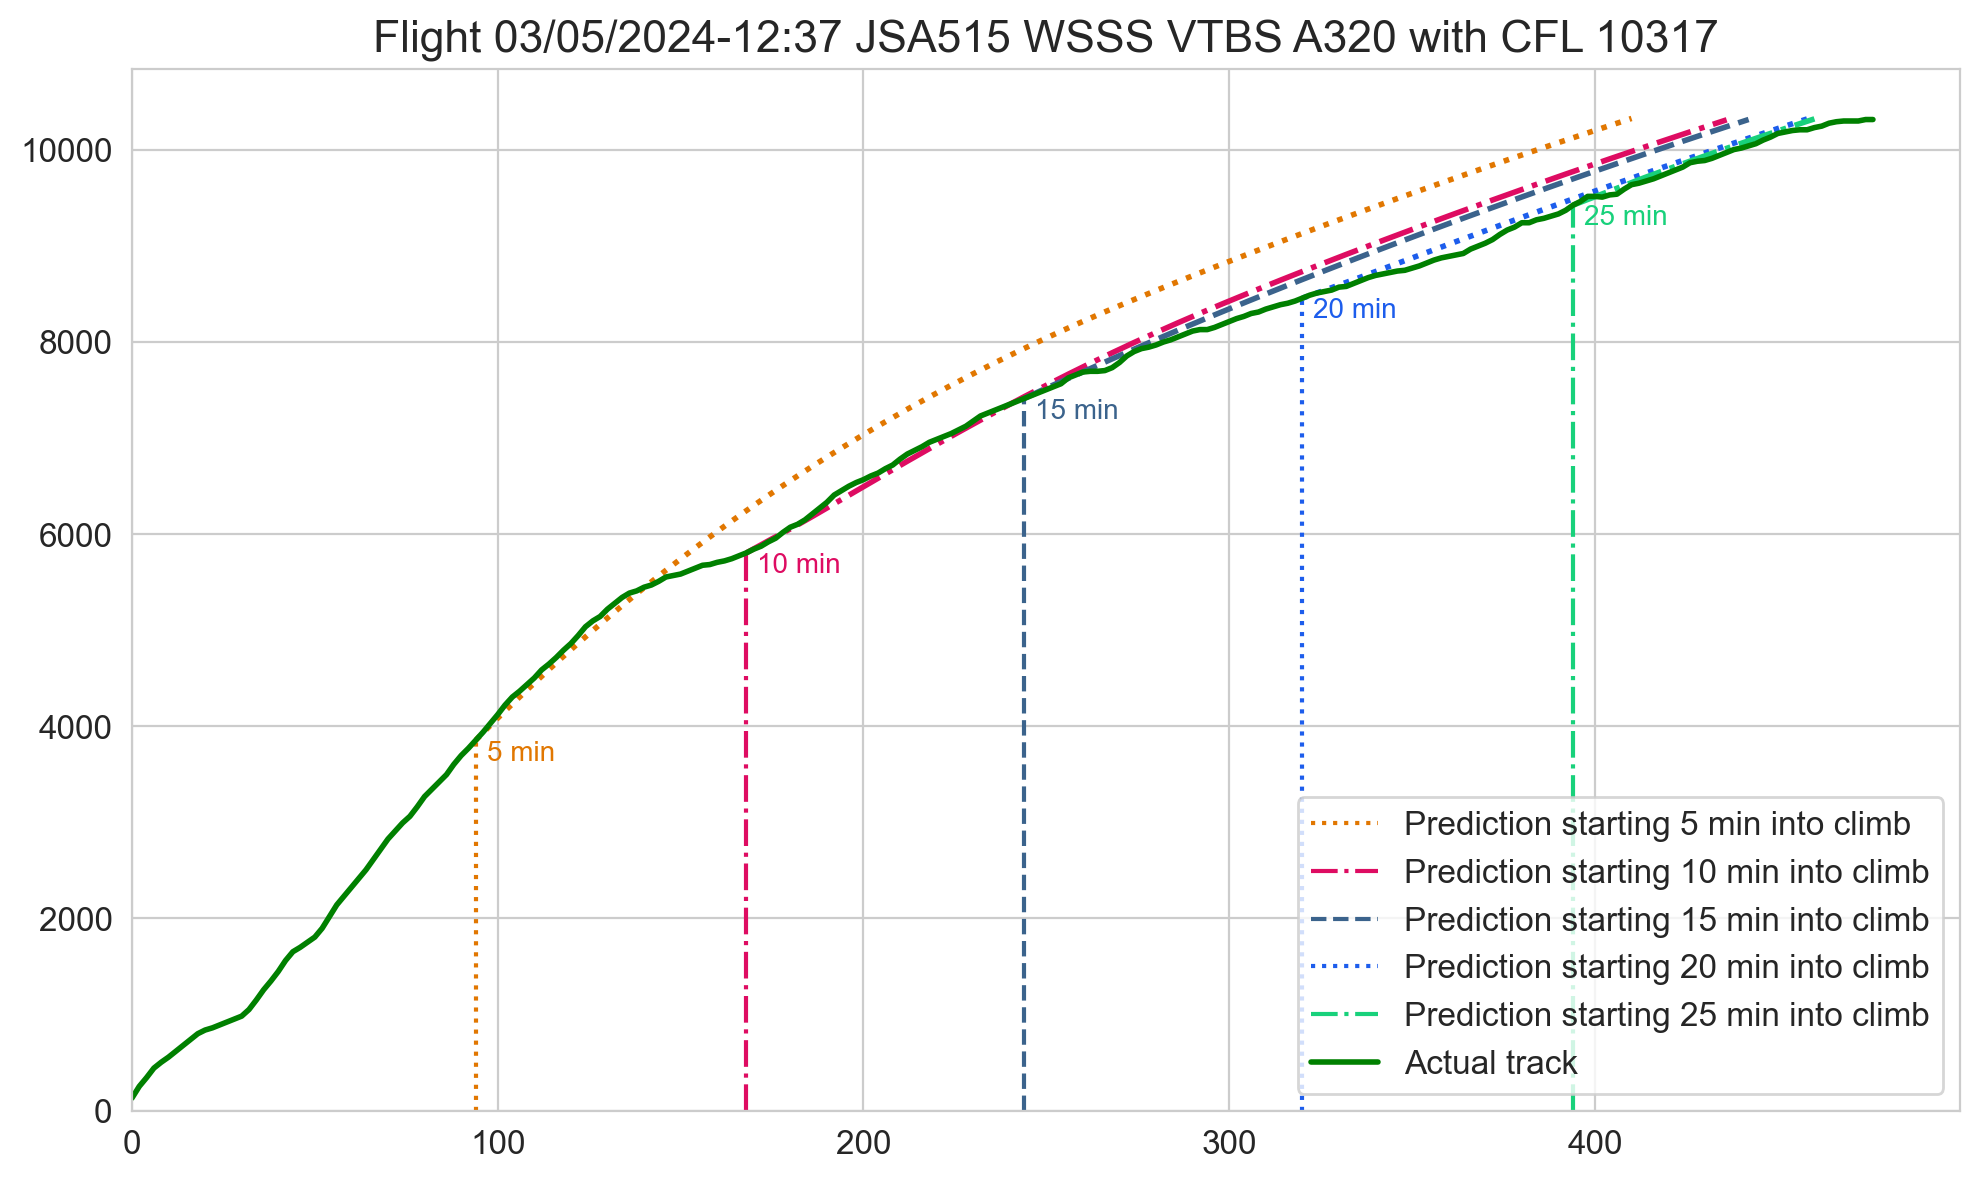


Sample 10 from test dataset


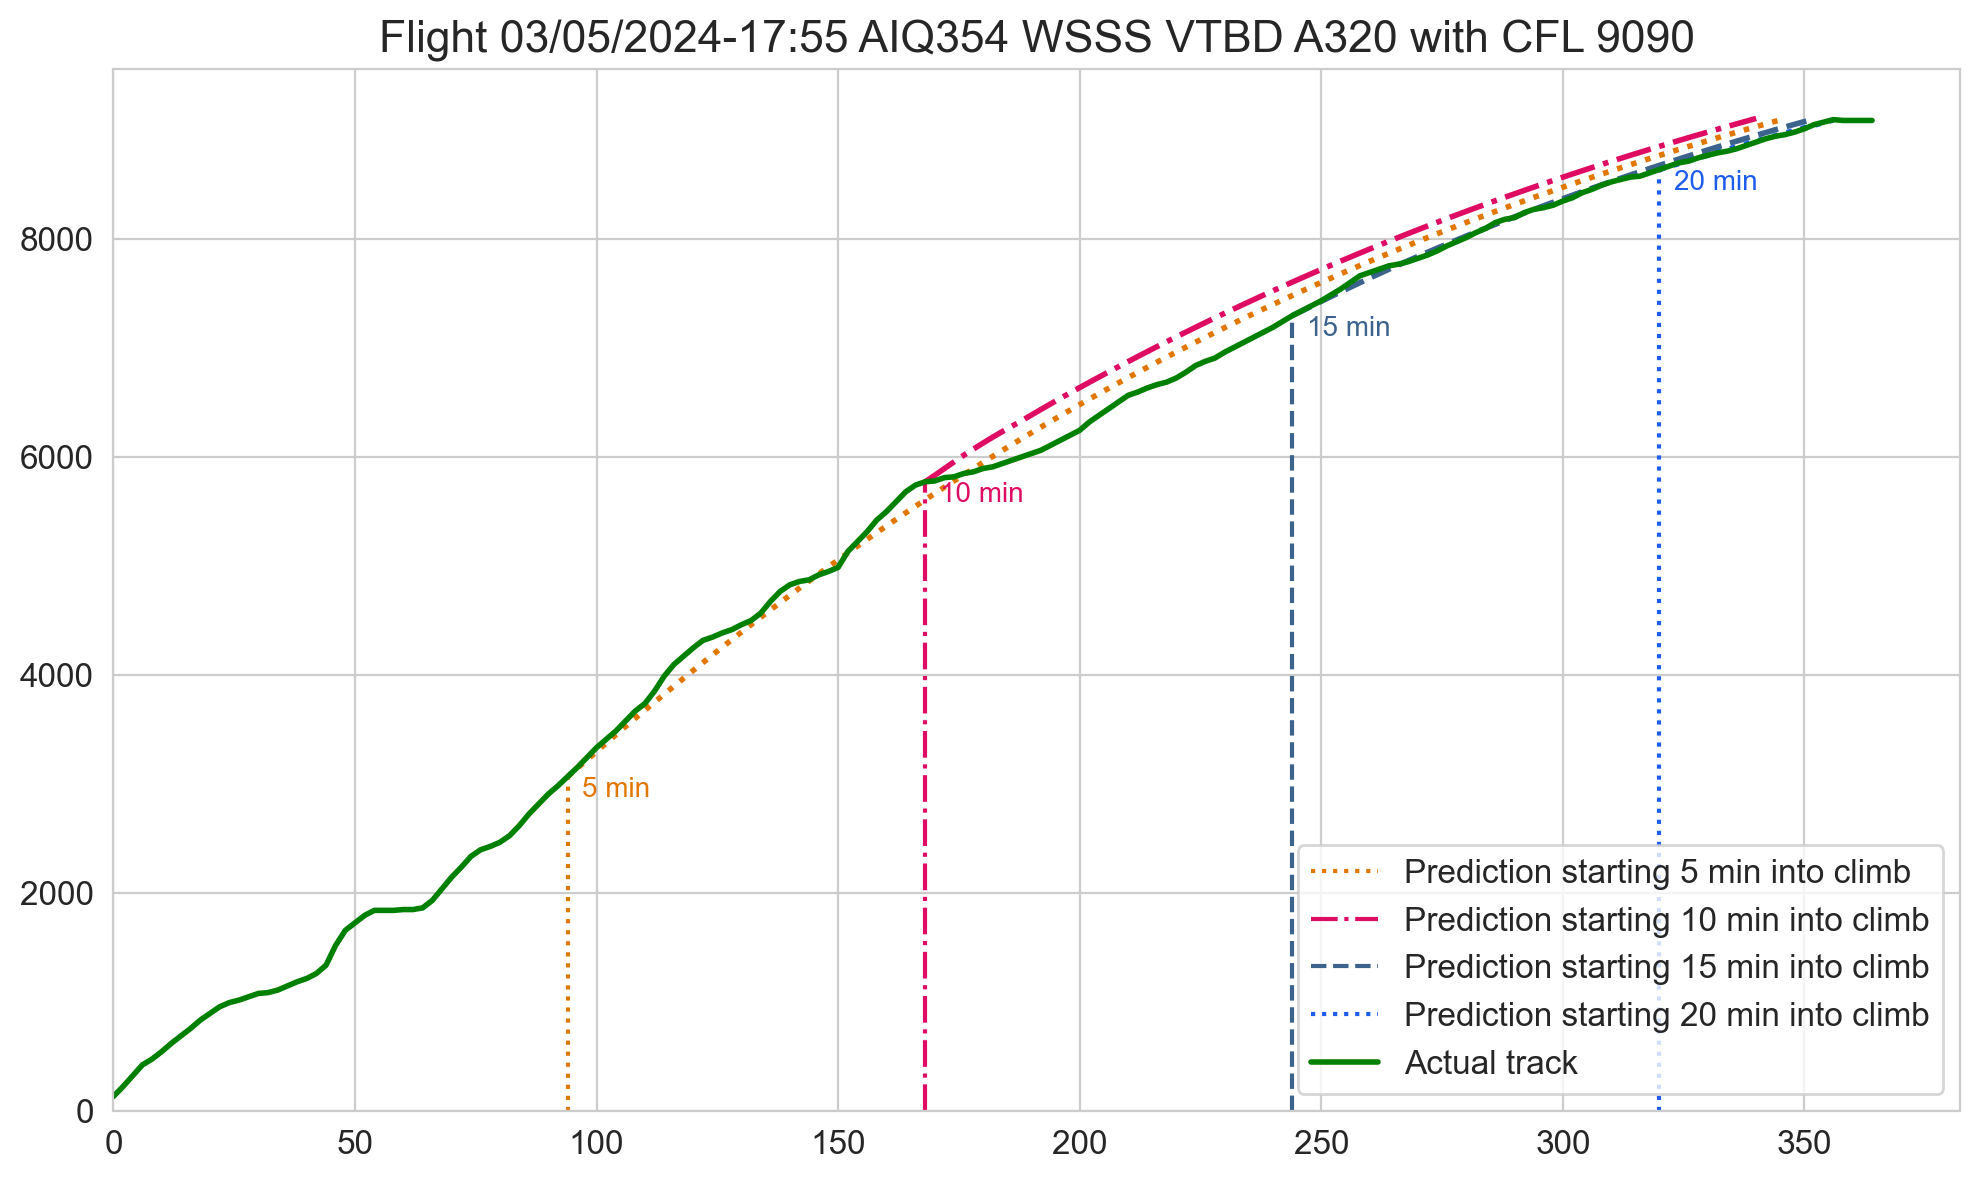


Sample 24 from test dataset


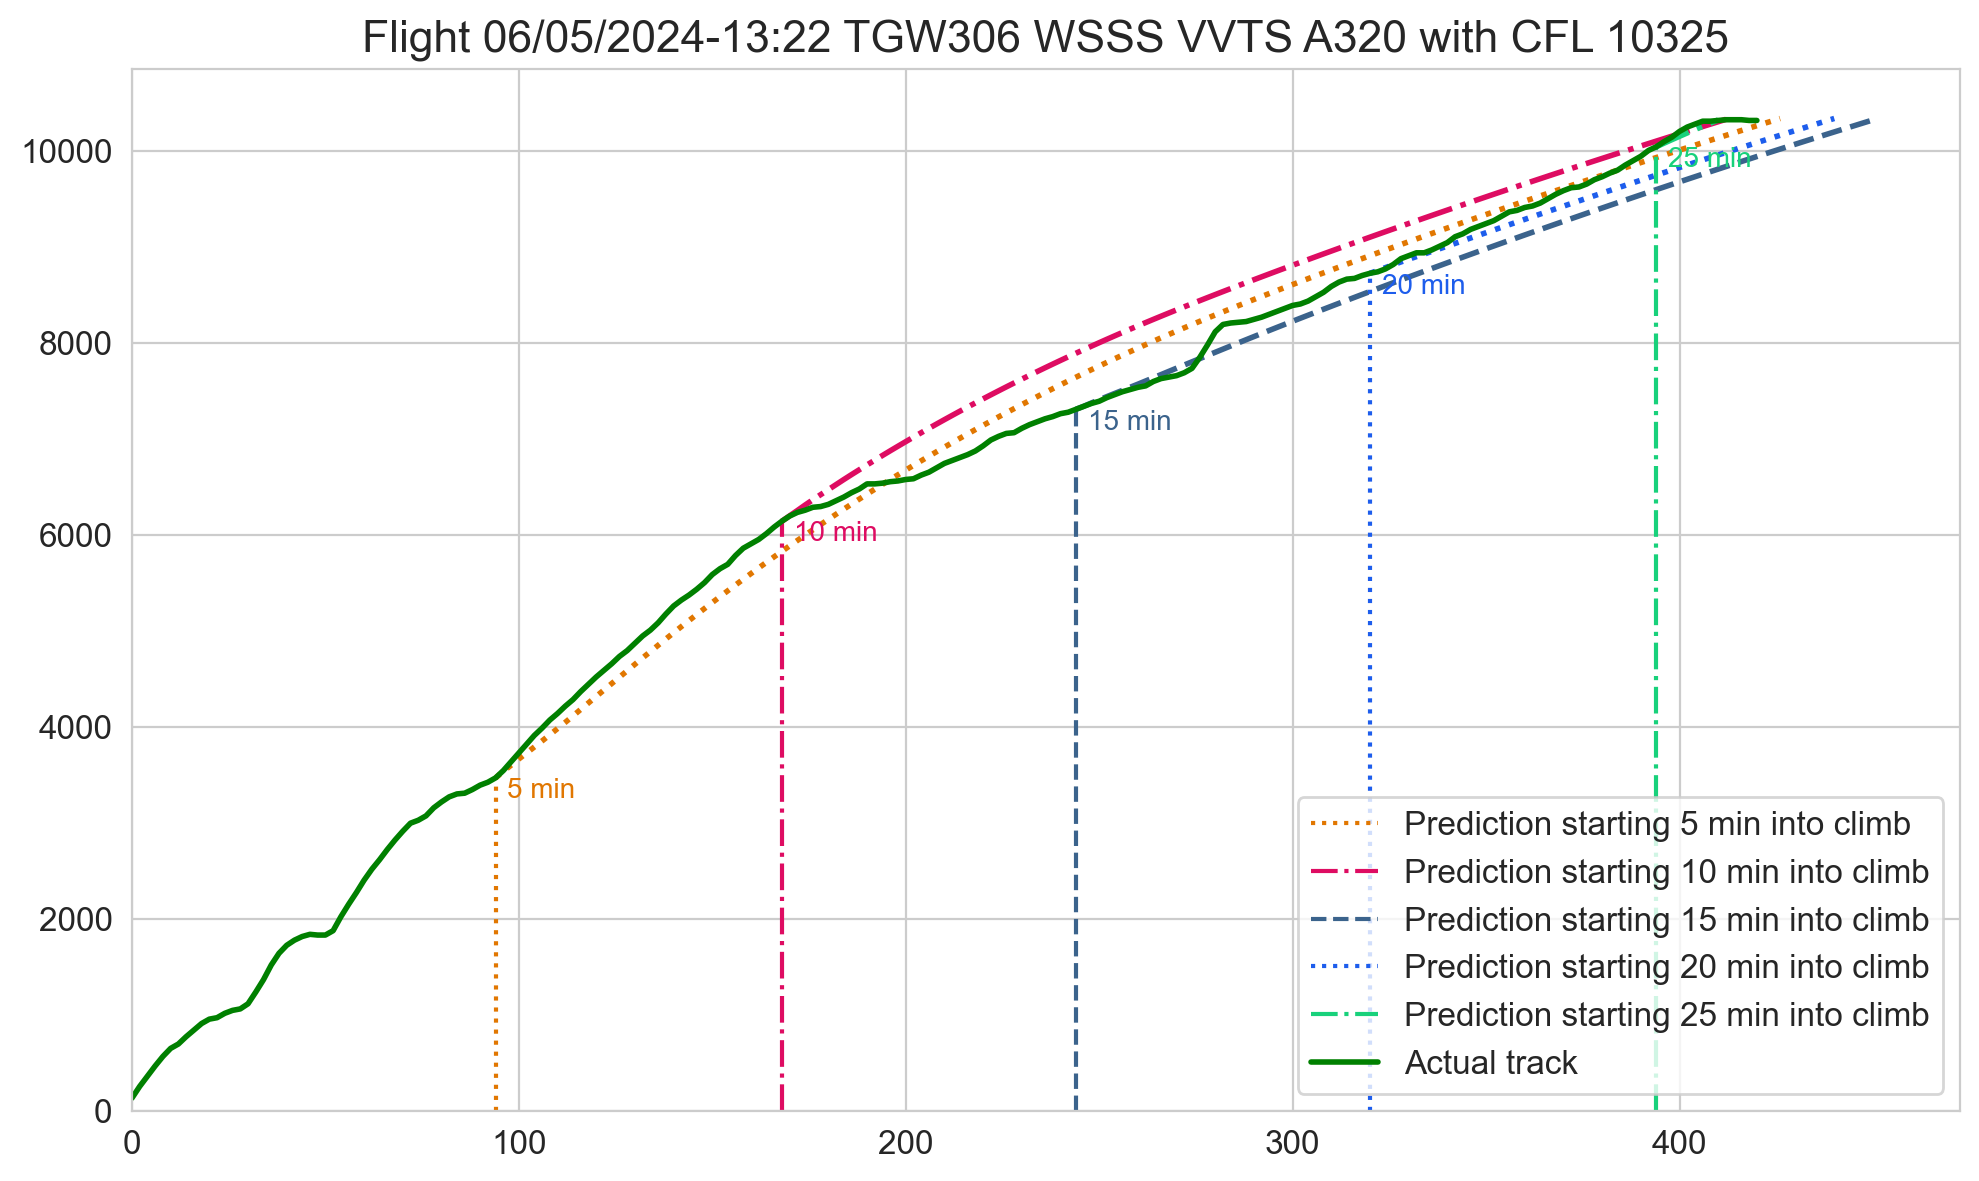


Sample 32 from test dataset


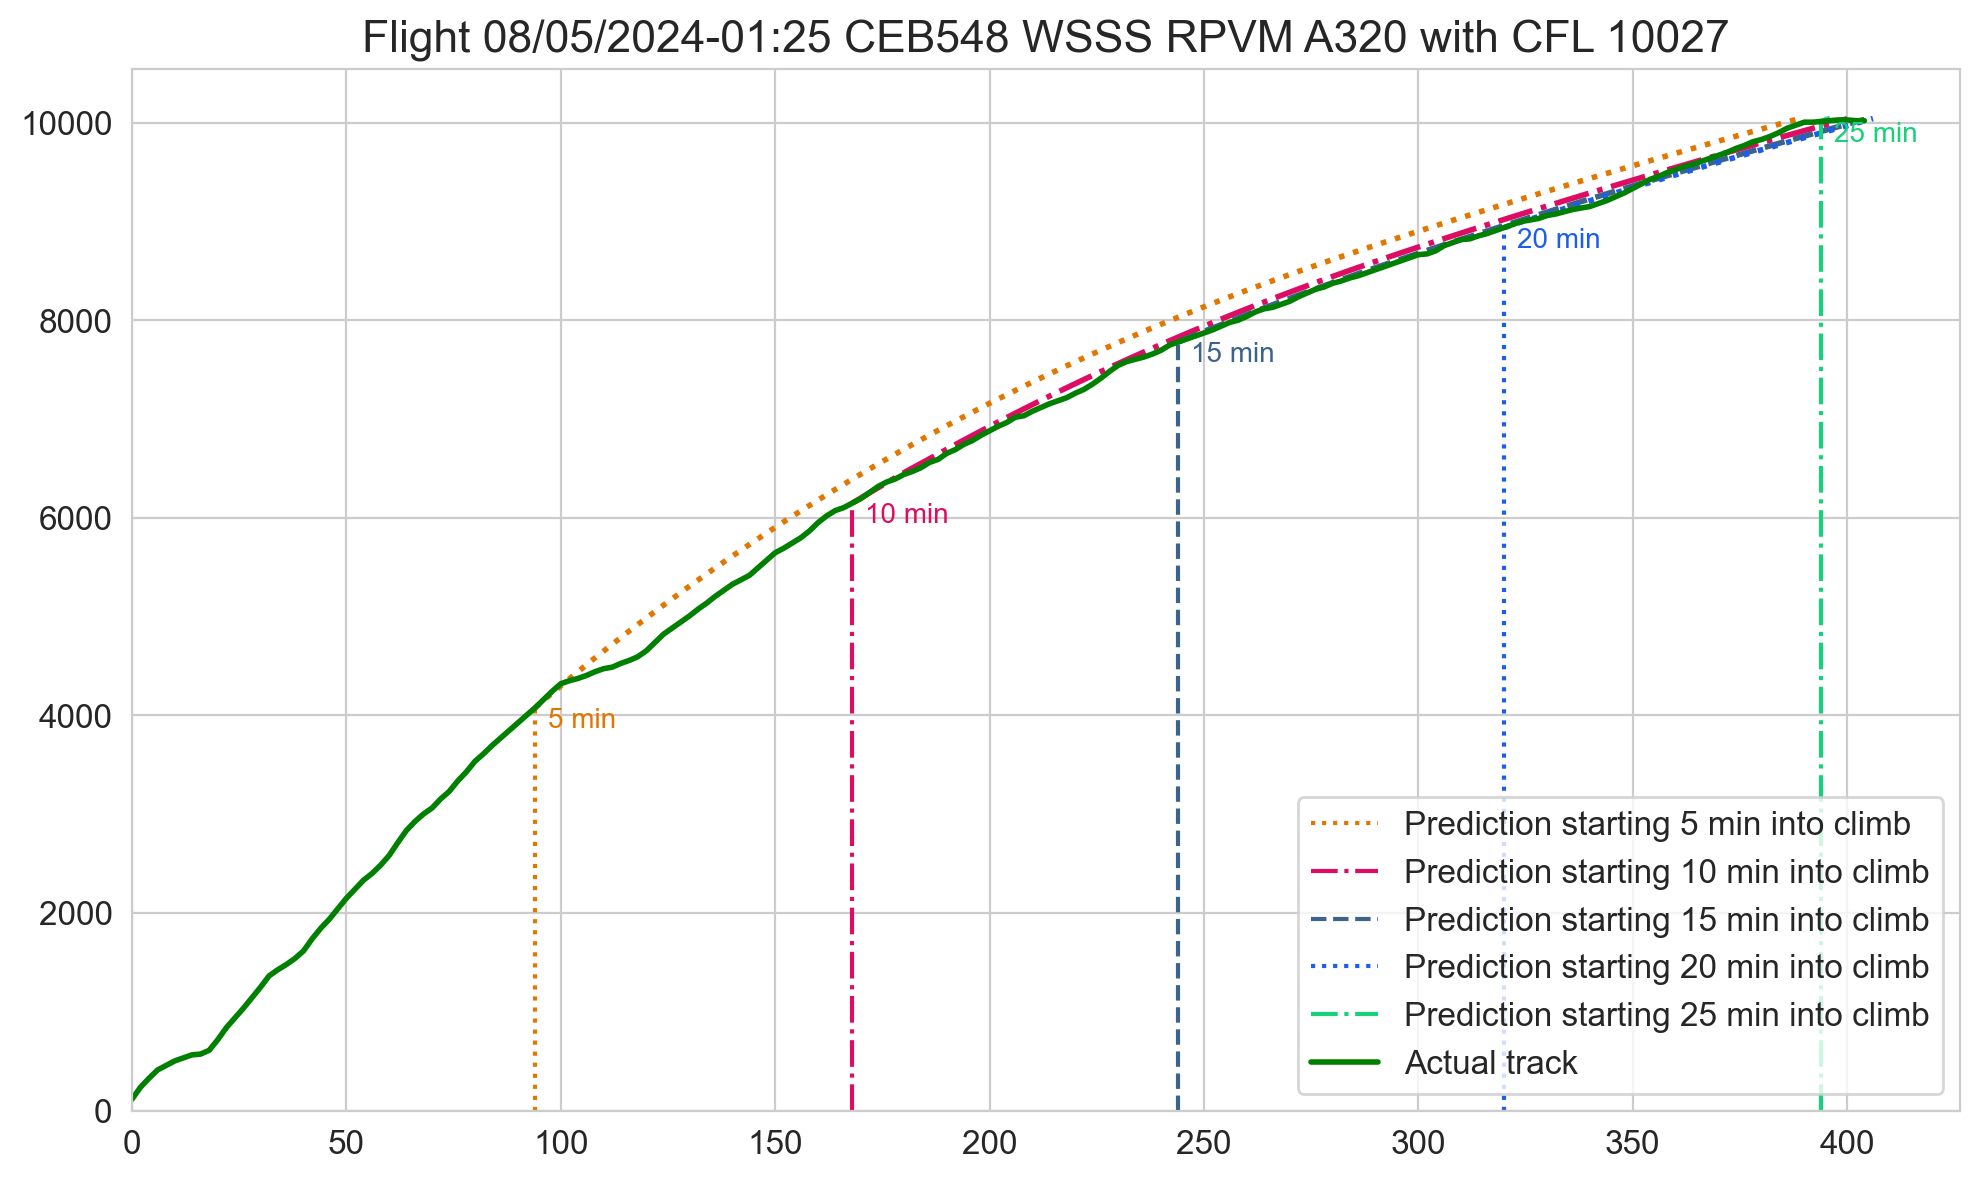


Sample 44 from test dataset


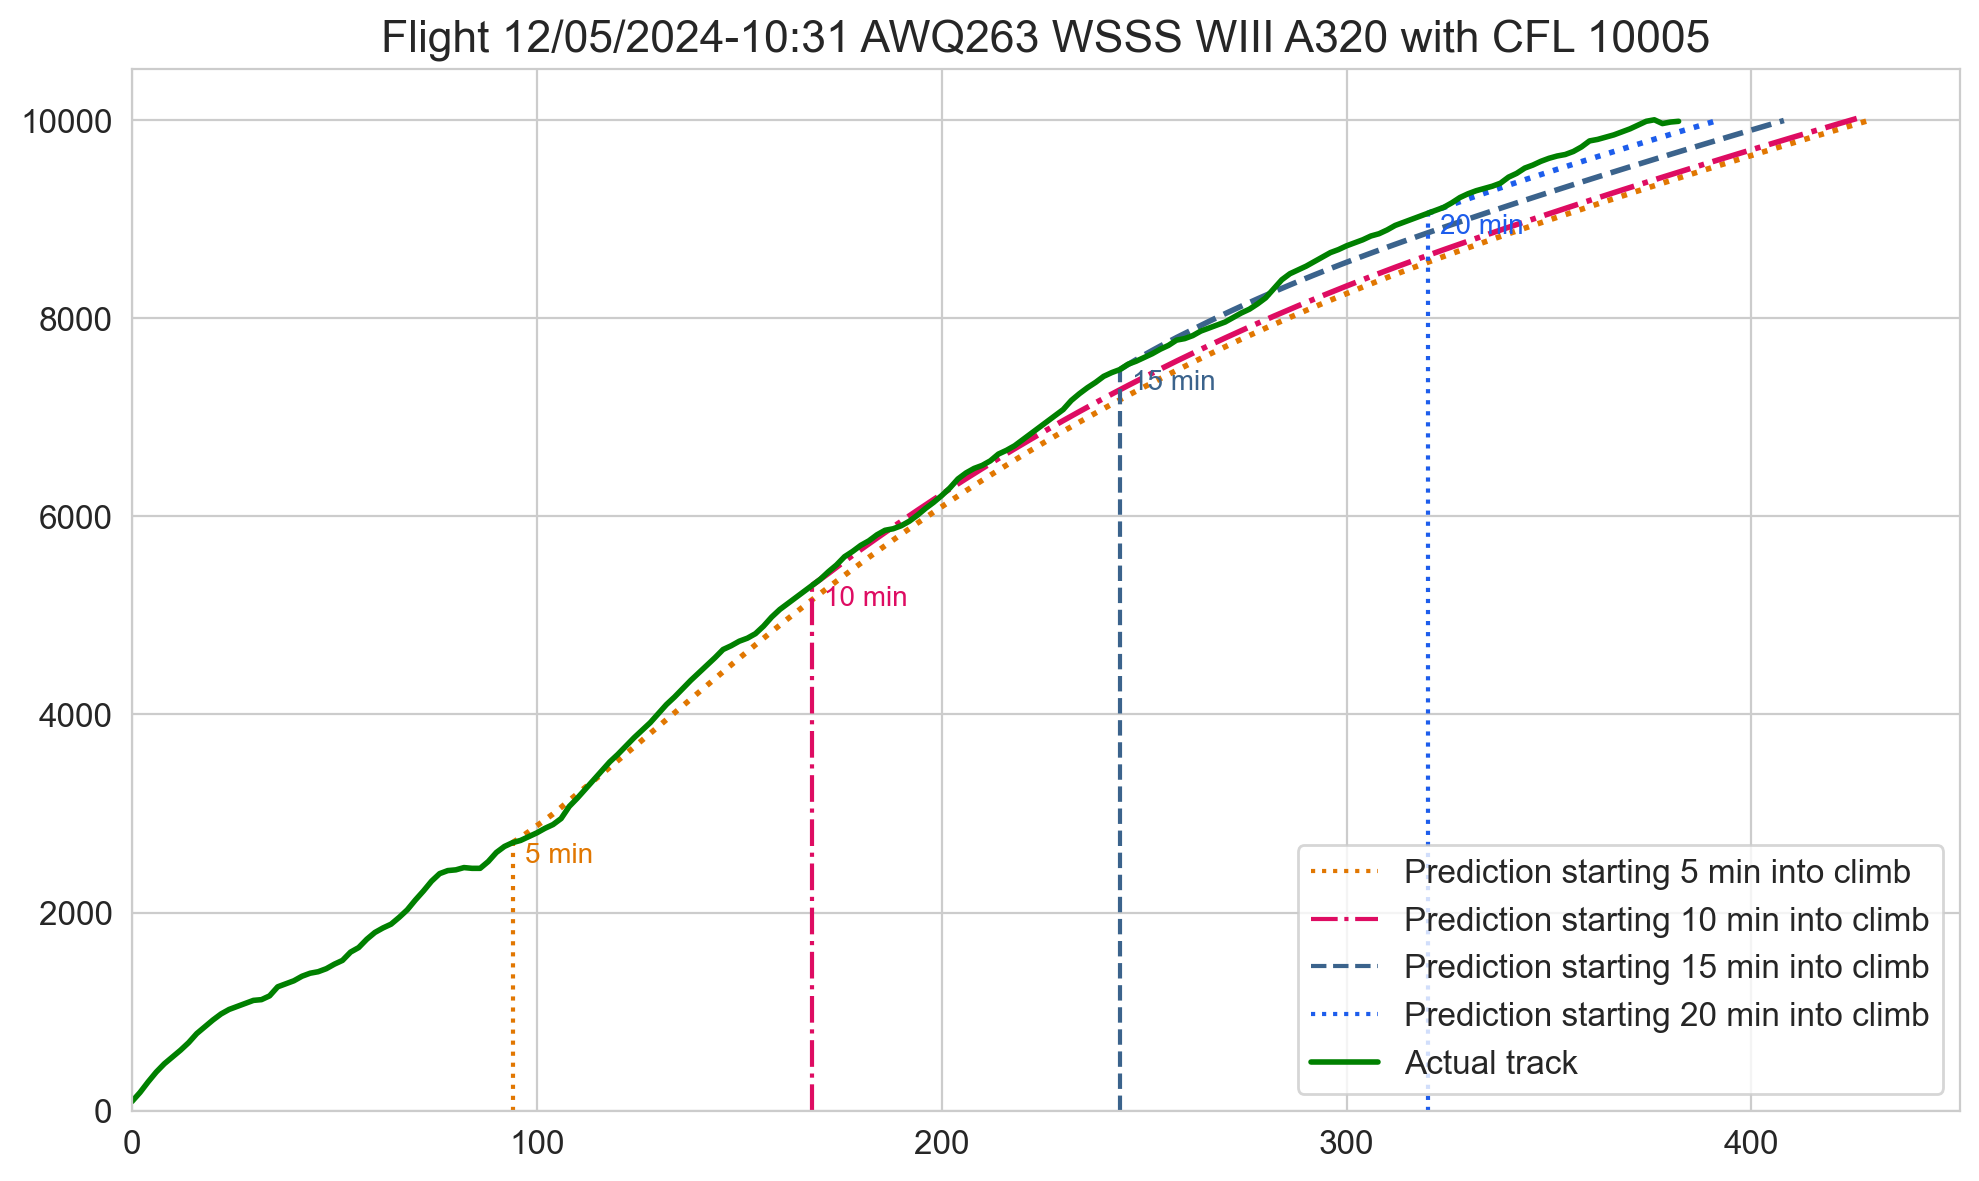


Sample 55 from test dataset


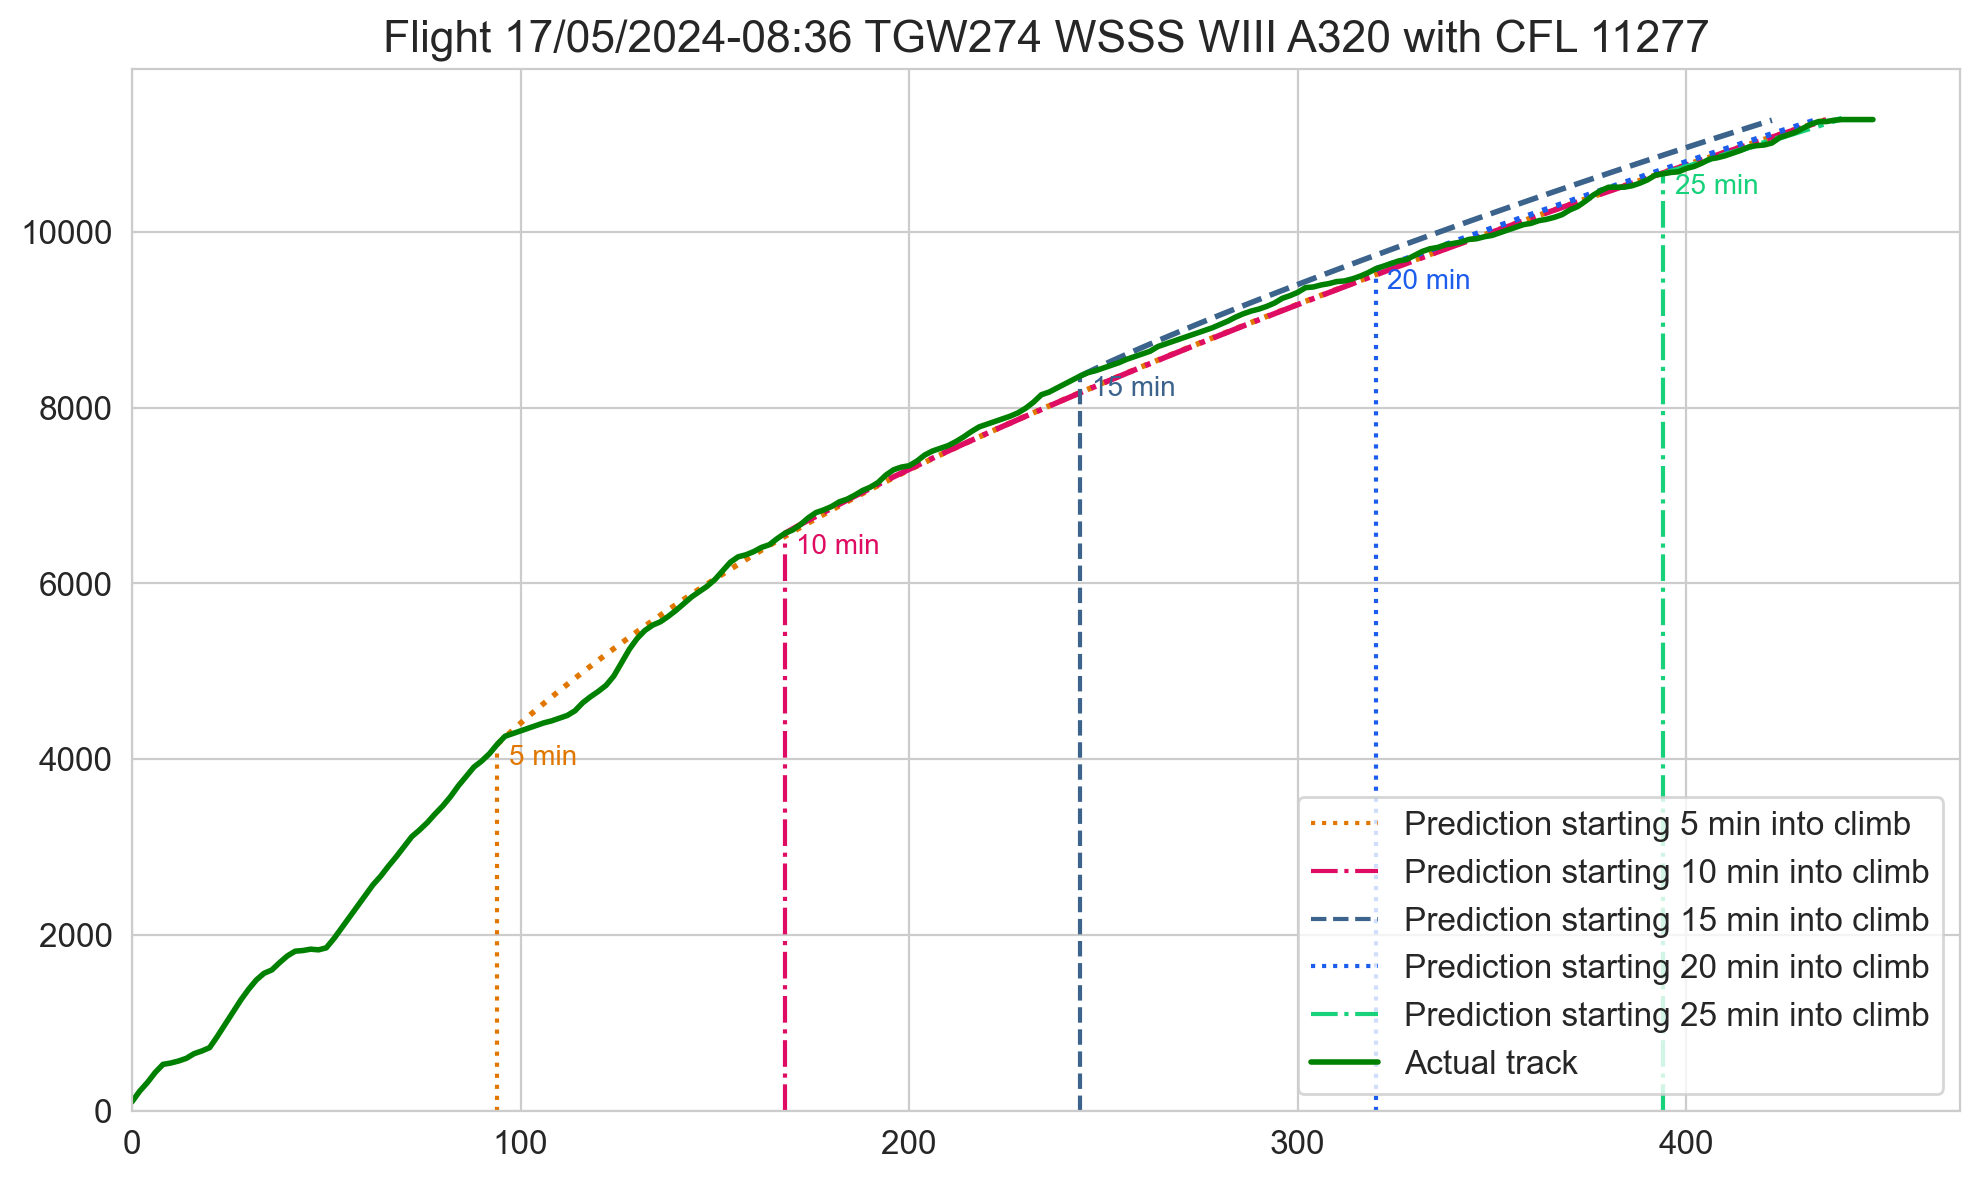

In [651]:
# 15 Flights to display

for n_flight_test in [1, 3, 4, 5, 7, 10, 24, 32, 44, 55]:
    # The chosen flight
    a_test_flight = test.flights[n_flight_test]
    flight_name = a_test_flight.flight_id.split("Copy")[0]

    print(f"\nSample {n_flight_test} from test dataset")

    for model in [model]:
        plt.figure(
            figsize=Fl.DEFAULTWIDEFIGSIZE,
            dpi=Fl.DEFAULTDPI,
            facecolor="w",
            edgecolor="k",
        )
        ax1 = plt.subplot()

        for start_prediction_sample, color, style, lag in [
            (sample_from_minutes(5), "xkcd:pumpkin", ":", "5 min"),
            (sample_from_minutes(10), "xkcd:cerise", "-.", "10 min"),
            (sample_from_minutes(15), "xkcd:denim", "--", "15 min"),
            (sample_from_minutes(20), "xkcd:azul", ":", "20 min"),
            (sample_from_minutes(25), "xkcd:seaweed", "-.", "25 min"),
        ]:
            # Check climb is long enough
            if len(a_test_flight.tracks) > start_prediction_sample + 2:
                # Predict climb
                time, pred_alt = predict_a_flight(
                    model=model,
                    flight=a_test_flight,
                    start_prediction_sample=start_prediction_sample,
                )

                # Plot with a vertical line
                plt.plot(
                    [time[0], time[0]],
                    [0, pred_alt[0]],
                    style,
                    color=color,
                    label=f"Prediction starting {lag} into climb",
                )
                plt.text(
                    time[0] + 3,
                    pred_alt[0],
                    lag,
                    verticalalignment="top",
                    color=color,
                )
                plt.plot(
                    time,
                    pred_alt,
                    style,
                    color=color,
                    linewidth=2,
                )

        # The real track
        plt.plot(
            a_test_flight.tracks["Time"],
            a_test_flight.tracks["Altitude"],
            "-",
            color="green",
            linewidth=2,
            label="Actual track",
        )

        ax1.set_xlim(left=0)
        ax1.set_ylim(bottom=0)
        ax1.grid(axis="y", zorder=-1)

        plt.title(
            f"Flight {flight_name}"
            + f" with CFL {int(a_test_flight.additional['alt_max'])}",
            fontsize=16,
        )
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()

## Measuring TP accuracy on test dataset

This section takes samples every minute to assess the average and standard deviation per minute for the five models

In [702]:
# At least 8 minutes climb

long_test = test.longer(11 * 60 // 8)

In [ ]:
import random


def measure_accuracy(model, samples):
    """
    Takes random samples from the validation data set
    and compares predictions with actual data every minute
    to be able to take stats on them

    Only complete samples are taken into account,
    masked samples are dropped
    """

    full_data = pd.DataFrame()

    for test_flight in random.sample(long_test.flights, samples):

        # Start randomly but not too late and not too early
        start_prediction_sample = random.randint(
            10, len(test_flight.tracks) - 62 - 30  # 62
        )

        # Predict climb
        time, pred_alt = predict_a_flight(
            model=model,
            flight=test_flight,
            start_prediction_sample=start_prediction_sample,
            up_to_CFL=True,
        )
        climb_prediction = pd.DataFrame(
            list(zip(time, pred_alt)), columns=["Time", "Pred_Alt"]
        )
        climb_prediction.set_index("Time", inplace=True, drop=False)

        # Initial values
        initial_time = time[0] - 2
        data_row_ = []

        # Cycling eight minutes
        for i_ in range(15, 151, 15):
            i_val = i_ // 2 * 2
            minutes_ = i_val / 15
            error_altitude = (
                test_flight.tracks["Altitude"].loc[initial_time + i_val]
                - climb_prediction["Pred_Alt"].loc[initial_time + i_val]
            )
            data_row_.append(abs(round(error_altitude * 3.28084 / minutes_)))

        full_data = pd.concat(
            [
                full_data,
                pd.DataFrame(
                    data_row_,
                    index=[str(n) + " min" for n in range(1, 11)],
                ).T,
            ],
            axis=0,
            ignore_index=True,
        )
    return full_data

### Table of error data

In [787]:
measure = measure_accuracy(model=model, samples=50)

output = pd.concat(
    [
        pd.DataFrame(measure.mean()).T.set_index([pd.Index(["Model mean"])]),
        pd.DataFrame(measure.std()).T.set_index([pd.Index(["Model std"])]),
    ]
)
output.round(decimals=1)

1 min  2 min  3 min  4 min  5 min  6 min  7 min  8 min  9 min  \
Model mean 346.00 277.60 250.30 212.10 171.30 154.50 141.90 128.80 113.30   
Model std  324.30 263.40 232.00 197.60 161.70 138.70 120.40 111.20  98.60   

            10 min  
Model mean  115.20  
Model std    91.50

### Boxplots of error data

In [ ]:
def error_boxplot(model, measure_df):
    """
    Renders box plot of a model given a set
    of error samples, longitudinal and lateral
    """
    plt.figure(dpi=Fl.DEFAULTDPI, facecolor="w", edgecolor="k", figsize=(6, 4))
    ax1 = plt.subplot()
    measure_df.boxplot(
        ax=ax1,
        column=[str(n) + " min" for n in range(1, 11)],
        rot=45,
        showmeans=True,
    )
    ax1.hlines(100, 0.5, 10.5, color="lightgreen", linestyles="--")
    ax1.set_xlabel("Prediction Minutes")
    ax1.set_ylabel("Prediction Error (ft/min)")
    ax1.set_ylim(0, 500)

    plt.title(f"TP Model: Climber", fontsize=16)

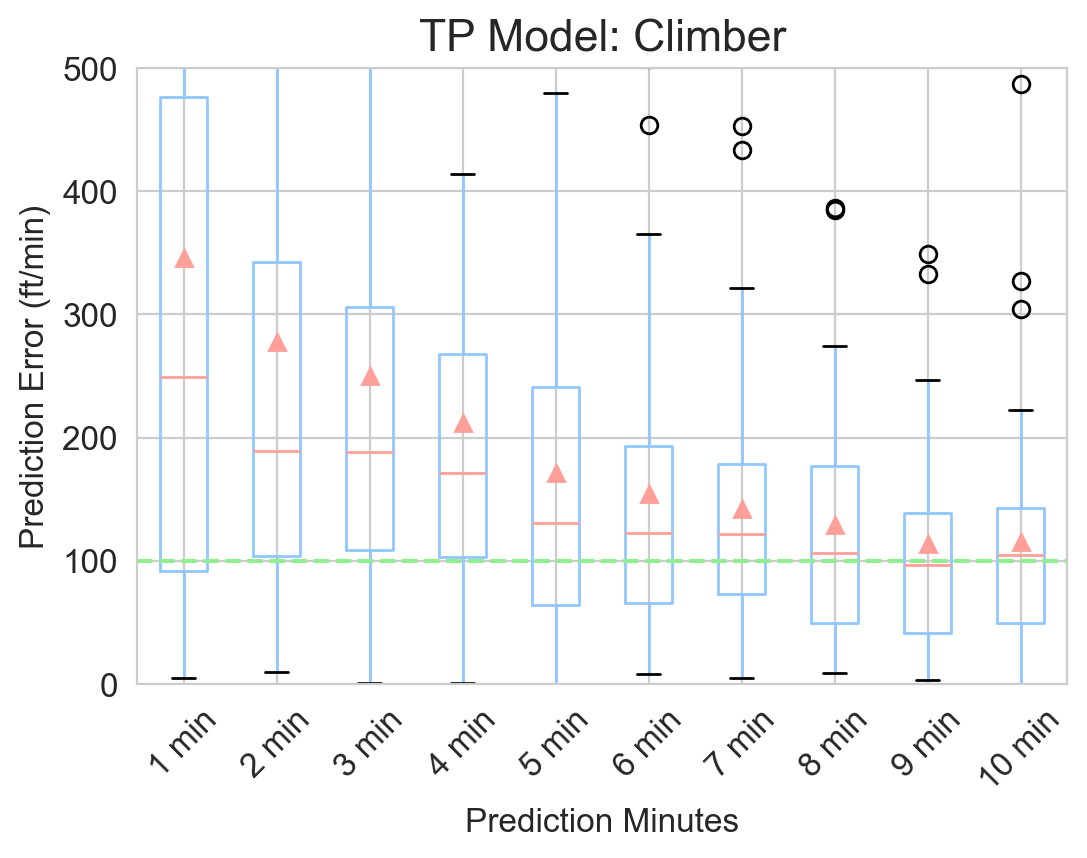

In [827]:
error_boxplot(model, measure)

In [815]:
train_log = pd.read_csv("logs/climber_training.csv")
dev_log = pd.read_csv("logs/climber_validation.csv")

In [ ]:
train_log = pd.merge(left=train_log, right=dev_log, on="Step").drop(
    columns=["Wall time_x", "Wall time_y"]
)
train_log

Step  Value_x  Value_y
0       5   638.86   635.91
1      19   628.02   623.71
2      37   625.94   621.08
3      38   625.86   620.95
4      58   624.43   618.89
..    ...      ...      ...
995  7959   605.16   601.80
996  7962   605.16   601.72
997  7963   605.15   601.80
998  7967   605.16   601.80
999  7972   605.16   601.77

[1000 rows x 3 columns]

Text(0.5, 1.0, 'TP Model: Climber - Training process')

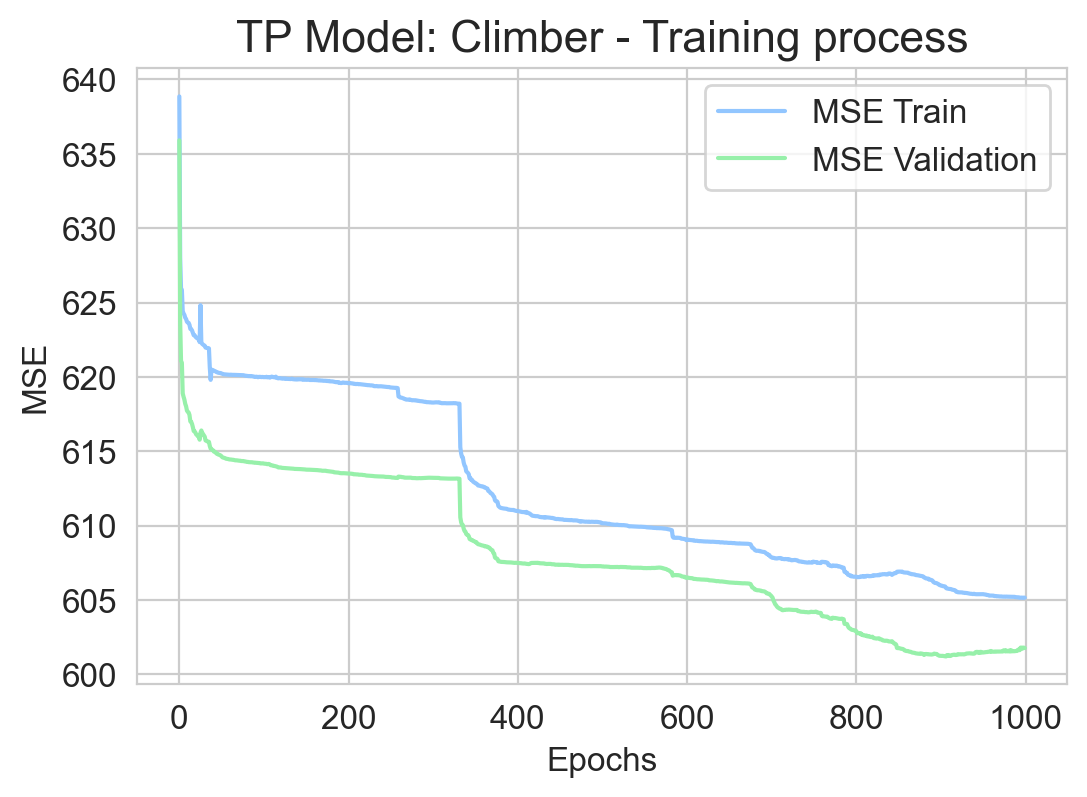

In [ ]:
plt.figure(dpi=Fl.DEFAULTDPI, facecolor="w", edgecolor="k", figsize=(6, 4))
ax1 = plt.subplot()
ax1.plot(train_log.Value_x, label="MSE Train")
ax1.plot(train_log.Value_y, label="MSE Validation")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("MSE")
ax1.legend()
plt.title(f"TP Model: Climber - Training process", fontsize=16)